# BrainGAT Evolution: Temporal-Spatial Graph Attention Network

---

## 📋 CHANGELOG (For Rollback Reference)

### Version 2.0.0 - Temporal Branch Enhancement (2025-12-18)

**1. Mean + Variance Dynamic Pooling** (Replaces AdaptiveAvgPool1d)
- **File**: `TemporalBranch` class
- **Change**: Replaced `self.pool = nn.AdaptiveAvgPool1d(1)` with combined mean + std pooling
- **Rollback**: Change `temporal_feats = torch.cat([mean_pool, std_pool], dim=-1)` back to `self.pool(x).squeeze(-1)` and restore `self.pool = nn.AdaptiveAvgPool1d(1)` in `__init__`
- **Reason**: ASD biomarkers appear in signal fluctuations/volatility, not just mean activation

**2. Branch Normalization (LayerNorm)**
- **File**: `TemporalSpatialBrainGAT` class
- **Change**: Added `self.temporal_norm = nn.LayerNorm(temporal_dim * 2)` and `self.spatial_norm = nn.LayerNorm(spatial_dim)`
- **Rollback**: Remove LayerNorm layers and their application in forward pass
- **Reason**: Puts temporal and spatial features on equal footing for the classifier

**3. Learnable Branch Scaling (α, β)**
- **File**: `TemporalSpatialBrainGAT` class
- **Change**: Added `self.temporal_scale = nn.Parameter(torch.ones(1))` and `self.spatial_scale = nn.Parameter(torch.ones(1))`
- **Rollback**: Remove scale parameters and multiplication in forward pass
- **Reason**: Allows optimizer to explicitly tune branch importance; monitor during training

**4. Temporal Context Adjustment (Stride 20)**
- **File**: Windowing configuration
- **Change**: Changed `STRIDE = 40` to `STRIDE = 20` (from 50% to 75% overlap)
- **Rollback**: Change `STRIDE = 20` back to `STRIDE = 40`
- **Reason**: More windows per subject captures faster dynamics for 1D-CNN

**5. Phase Synchrony Ablation Option**
- **File**: `build_multiscale_graphs()` function
- **Change**: Added `exclude_phase_sync=False` parameter to optionally remove phase sync from edges
- **Rollback**: Remove the `exclude_phase_sync` parameter and conditional logic
- **Reason**: Phase sync may be "stealing" temporal info from temporal branch

---

## Overview

This notebook extends the baseline BrainGAT model with novel architectural improvements for ASD classification using **IMAGING-ONLY fMRI data** from the full ABIDE dataset.

---

## Dataset: ABIDE (Autism Brain Imaging Data Exchange)

- **Full Dataset**: ~1,100+ subjects across 20+ sites
- **Data Used**: Complete set with available resting-state fMRI (all successfully downloaded .1D files)
- **Features**: **IMAGING ONLY** - No demographic/phenotypic data used for classification
  - Raw fMRI timeseries: 196 timepoints × 392 ROIs (CC400 atlas)
  - Derived connectivity features: Correlation, Partial Correlation, Mutual Information, Phase Synchrony
- **Labels**: Binary (Control vs ASD) from phenotype file (for ground truth only)

---

## Baseline BrainGAT (What We Started With)

### Architecture:
- **Input**: Correlation matrix (392×392) derived from fMRI timeseries
- **Graph Construction**: k-NN (k=20) based on correlation magnitude
- **Node Features**: Correlation vectors (each ROI's correlations to all other ROIs)
- **Edge Features**: Scalar correlation values
- **Network**: 3-layer GAT with multi-head attention (4 heads)
- **Pooling**: Global mean + max pooling
- **Output**: MLP classifier (2 classes: Control vs ASD)

### Limitations:
1. **Temporal Information Loss**: 196 timepoints collapsed into static correlation matrix
2. **Weak Edge Features**: Only using correlation magnitude (scalar)
3. **Fixed Graph Structure**: k-NN graph doesn't adapt during training
4. **No Multi-Scale Modeling**: Single receptive field for all attention heads
5. **Limited Interpretability**: No mechanism to identify important ROIs or timepoints

### Performance (351 subjects subset):
- Accuracy: ~52% (barely better than random)
- ASD Recall: ~16% (fails to detect ASD)
- **Problem**: Heavy bias toward majority class (Control)

---

## Evolution: What We're Adding

### 1. **Temporal-Spatial Joint Modeling**
**Motivation**: fMRI data has rich temporal dynamics (196 timepoints) that we're currently discarding.

**Implementation**:
- **Temporal Branch**: 1D Conv + Temporal Attention on raw timeseries
  - Learns dynamic patterns (e.g., periodic activations, bursts)
  - Captures temporal dependencies between timepoints
  - **NEW v2.0**: Uses Mean + Variance pooling to capture signal volatility
- **Spatial Branch**: GAT on correlation graph (as before)
  - Learns which ROI connections are important
- **Fusion**: Concatenate temporal + spatial features before classification
  - **NEW v2.0**: LayerNorm + Learnable scaling for balanced fusion

**Expected Gain**: +5-10% accuracy by exploiting temporal information

### 2. **Rich Edge Features**
**Motivation**: Brain connections have multiple properties beyond correlation.

**Implementation**:
Replace scalar edge weights with 4D edge features:
- **Pearson Correlation**: Linear relationship strength
- **Partial Correlation**: Direct connection (removing confounds)
- **Mutual Information**: Non-linear dependencies
- **Phase Synchrony**: Temporal alignment of signals (optional in v2.0)

**Expected Gain**: +3-5% accuracy by capturing diverse connectivity patterns

### 3. **Multi-Scale Graph Construction**
**Motivation**: Brain operates at multiple spatial scales (local circuits → networks → whole-brain).

**Implementation**:
- Build 3 graphs with different connectivity radii:
  - **Local** (k=10): Short-range connections within regions
  - **Regional** (k=30): Medium-range connections between nearby areas
  - **Global** (k=100): Long-range connections (e.g., DMN)
- Run separate GATs on each scale
- Concatenate multi-scale features

**Expected Gain**: +4-7% accuracy by capturing hierarchical organization

### 4. **Full Dataset Utilization**
- Using **all available subjects** from ABIDE (not just 351)
- Expected ~800-1000 subjects after quality control
- More data = better generalization

---

## Architecture Diagram

```
Input: fMRI Timeseries (N=392 ROIs, T=196 timepoints)
         |
         ├─────────────────┬──────────────────┐
         ↓                 ↓                  ↓
   TEMPORAL BRANCH   SPATIAL BRANCH   EDGE FEATURES
         |                 |                  |
   1D Conv (T→64)    Correlation Matrix   Pearson Corr
         |                 |              Partial Corr
   Temporal Attn     k-NN Graph (3 scales)  Mutual Info
         |                 |              Phase Sync*
   Mean+Var Pool     Multi-Scale GAT        |
   (NEW: volatility)       |                  |
         |                 |                  |
   LayerNorm         LayerNorm              |
   α-scaling         β-scaling              |
         └─────────────────┴──────────────────┘
                           ↓
                   Concatenate Features
                           ↓
                      MLP Classifier
                           ↓
                  [Control / ASD]

* Phase Sync can be excluded for ablation (--exclude_phase_sync)
```

---

## Expected Performance

- **Baseline BrainGAT** (351 subjects): 52% accuracy, 16% ASD recall
- **Target (Evolution v2.0)**: 70-75% accuracy, 60-70% ASD recall
- This would be competitive with state-of-the-art on ABIDE (BrainGNN: 71-74%)

---

## Novelty Contributions

1. **Joint Temporal-Spatial Modeling**: First to combine 1D temporal convolutions with graph attention for fMRI
2. **Dynamic Variance Pooling**: Captures signal volatility critical for ASD biomarkers
3. **Balanced Branch Fusion**: LayerNorm + learnable scaling prevents branch dominance
4. **Multi-Modal Edge Features**: Using 4 complementary connectivity measures simultaneously
5. **Multi-Scale Hierarchical GAT**: Explicitly modeling brain's hierarchical organization
6. **Imaging-Only**: Pure neuroimaging approach (no demographic confounds)

---

Let's implement it!

In [2]:
!nvidia-smi
import torch
import matplotlib.pyplot as plt
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

Mon Jan  5 19:42:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Imports & Setup
import os
import sys
import subprocess
import importlib
import torch

def install_dependencies():
    print("Installing torch-geometric and dependencies...")
    torch_ver = torch.__version__.split('+')[0]
    cuda_ver = "cpu"
    
    if torch.cuda.is_available():
        cuda_ver = "cu" + torch.version.cuda.replace('.', '')
    
    wheel_url = f"https://data.pyg.org/whl/torch-{torch_ver}+{cuda_ver}.html"
    print(f"   Targeting wheels from: {wheel_url}")

    pkgs = ["torch-scatter", "torch-sparse", "torch-geometric"]
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs + ["-f", wheel_url]
    
    try:
        subprocess.check_call(cmd)
        print("Dependencies installed.")
    except subprocess.CalledProcessError:
        print("Warning: Wheel installation failed, falling back to default pip install...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

    importlib.invalidate_caches()

try:
    import torch_geometric
except ImportError:
    install_dependencies()

import torch_geometric
import glob
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
from scipy import stats
from sklearn.feature_selection import mutual_info_regression

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"   GPU: {gpu_name}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
   GPU: Tesla P100-PCIE-16GB
   Memory: 17.06 GB


In [4]:
# Enhanced Data Loading with Temporal Features & Rich Edge Features
import numpy as np
import pandas as pd
from glob import glob
import torch
from torch_geometric.data import Data
from pathlib import Path

def load_timeseries_1d(path: str) -> np.ndarray:
    """Load .1D file as T×N array (196 timepoints × 392 ROIs)"""
    arr = np.loadtxt(path)
    
    # Ensure correct orientation: T×N (196×392)
    # Some files may be stored as N×T, so transpose if needed
    if arr.shape[0] == 392 and arr.shape[1] == 196:
        arr = arr.T
    elif arr.shape[0] != 196 or arr.shape[1] != 392:
        # Skip files with unexpected dimensions
        raise ValueError(f"Unexpected dimensions: {arr.shape}. Expected (196, 392) or (392, 196)")
    
    return arr

def compute_partial_correlation(ts: np.ndarray) -> np.ndarray:
    """Compute partial correlation matrix (removes indirect effects)"""
    corr = np.corrcoef(ts, rowvar=False)
    try:
        # Add small regularization to ensure positive definiteness
        corr_reg = corr + np.eye(corr.shape[0]) * 1e-6
        
        # Partial correlation = negative normalized inverse covariance
        precision = np.linalg.inv(corr_reg)
        
        # Take absolute value of diagonal before sqrt to avoid negatives
        diag_vals = np.diag(precision)
        diag = np.sqrt(np.abs(diag_vals))
        
        # Avoid division by zero
        diag = np.where(diag < 1e-10, 1e-10, diag)
        
        partial = -precision / np.outer(diag, diag)
        np.fill_diagonal(partial, 1.0)
        
        # Clip to valid correlation range and handle NaNs
        partial = np.clip(partial, -1.0, 1.0)
        partial = np.nan_to_num(partial, nan=0.0, posinf=0.0, neginf=0.0)
        
        return partial
    except np.linalg.LinAlgError:
        return np.zeros_like(corr)

def compute_mutual_information(ts: np.ndarray) -> np.ndarray:
    """Compute mutual information matrix (captures non-linear dependencies)"""
    from scipy.stats import spearmanr
    import warnings
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mi_matrix, _ = spearmanr(ts, axis=0)
    
    mi_matrix = np.abs(mi_matrix)
    mi_matrix = np.nan_to_num(mi_matrix, nan=0.0, posinf=0.0, neginf=0.0)
    
    max_val = np.max(mi_matrix)
    if max_val > 1e-8:
        mi_matrix = mi_matrix / max_val
    
    return mi_matrix

def compute_phase_synchrony(ts: np.ndarray) -> np.ndarray:
    """Compute phase synchronization via Hilbert transform (vectorized)"""
    from scipy.signal import hilbert
    
    N = ts.shape[1]
    analytic = hilbert(ts, axis=0)
    phases = np.angle(analytic)
    
    phase_diff = phases[:, :, np.newaxis] - phases[:, np.newaxis, :]
    plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))
    
    return plv

def build_multiscale_graphs(ts: np.ndarray, k_values=[10, 30, 100]):
    """Build multiple graphs at different connectivity scales"""
    import warnings
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        
        corr = np.corrcoef(ts, rowvar=False)
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        corr = np.clip(corr, -1.0, 1.0)
        
        partial = compute_partial_correlation(ts)
        
        ts_downsampled = ts[::4, :]
        mi = compute_mutual_information(ts_downsampled)
        plv = compute_phase_synchrony(ts_downsampled)
    
    N = corr.shape[0]
    graphs = []
    
    for k in k_values:
        np.fill_diagonal(corr, 0.0)
        absC = np.abs(corr)
        k_eff = min(k, max(1, N - 1))
        
        edge_src, edge_dst, edge_feats = [], [], []
        
        for i in range(N):
            nbrs = np.argpartition(absC[i], -k_eff)[-k_eff:]
            for j in nbrs:
                if i != j:
                    edge_src.append(i)
                    edge_dst.append(j)
                    edge_feats.append([corr[i, j], partial[i, j], mi[i, j], plv[i, j]])
        
        edge_index = np.vstack([edge_src + edge_dst, edge_dst + edge_src])
        edge_attr = np.vstack([edge_feats, edge_feats])
        
        pairs = {}
        for idx, (s, d) in enumerate(edge_index.T):
            key = (min(s, d), max(s, d))
            if key not in pairs:
                pairs[key] = edge_attr[idx]
        
        final_edges = list(pairs.keys())
        final_src = [e[0] for e in final_edges]
        final_dst = [e[1] for e in final_edges]
        final_attr = np.array([pairs[e] for e in final_edges])
        
        final_src_bi = final_src + final_dst
        final_dst_bi = final_dst + final_src
        final_attr_bi = np.vstack([final_attr, final_attr])
        
        edge_index_tensor = torch.tensor([final_src_bi, final_dst_bi], dtype=torch.long)
        edge_attr_tensor = torch.tensor(final_attr_bi, dtype=torch.float)
        
        graphs.append((edge_index_tensor, edge_attr_tensor))
    
    return graphs, corr

def graph_from_timeseries_enhanced(timeseries: np.ndarray, k_values=[10, 30, 100]):
    """Build enhanced graph with temporal features + multi-scale spatial graphs"""
    ts_tensor = torch.tensor(timeseries.T, dtype=torch.float)
    graphs, corr = build_multiscale_graphs(timeseries, k_values)
    x = torch.tensor(corr, dtype=torch.float)
    
    data = Data(
        x=x,
        timeseries=ts_tensor,
    )
    
    for i, (edge_idx, edge_attr) in enumerate(graphs):
        setattr(data, f'edge_index_{i}', edge_idx)
        setattr(data, f'edge_attr_{i}', edge_attr)
    
    return data

def load_abide_graphs_enhanced(data_dir, phenotype_file, k_values=[10, 30, 100]):
    """Load ABIDE with enhanced features"""
    pheno_df = pd.read_csv(phenotype_file)
    roi_files = sorted(glob(f'{data_dir}/*.1D'))
    
    print(f"Loading ABIDE data (Enhanced Mode)...")
    print(f"   Multi-scale k values: {k_values}")
    print(f"   Edge features: [Correlation, Partial Corr, MI, Phase Sync]")
    
    graphs, labels, subjects = [], [], []
    
    site_map = {
        'MaxMun': 'MAX_MUN', 'Leuven_1': 'LEUVEN_1', 'Leuven_2': 'LEUVEN_2',
        'UCLA_1': 'UCLA_1', 'UCLA_2': 'UCLA_2', 'UM_1': 'UM_1', 'UM_2': 'UM_2',
        'Trinity': 'TRINITY', 'Yale': 'YALE', 'Olin': 'OLIN', 'OHSU': 'OHSU',
        'SBL': 'SBL', 'SDSU': 'SDSU', 'Stanford': 'STANFORD', 'Caltech': 'CALTECH',
        'CMU': 'CMU', 'KKI': 'KKI', 'NYU': 'NYU', 'Pitt': 'PITT', 'USM': 'USM'
    }
    
    for idx, file_path in enumerate(roi_files):
        if idx % 50 == 0:
            print(f"   Processing subject {idx+1}/{len(roi_files)}...")
        
        try:
            filename = Path(file_path).stem
            parts = filename.replace('_rois_cc400', '').split('_')
            
            if len(parts) < 2:
                continue
            
            site = parts[0]
            subject_id_idx = 1
            
            if len(parts) > 2 and parts[1].isdigit() and len(parts[1]) == 1:
                site = f"{parts[0]}_{parts[1]}"
                subject_id_idx = 2
            
            if site in site_map:
                site = site_map[site]
            elif site.upper() in site_map.values():
                site = site.upper()
            
            subject_id = None
            for part in parts[subject_id_idx:]:
                try:
                    subject_id = int(part)
                    break
                except ValueError:
                    continue
            
            if subject_id is None:
                continue
            
            subject_row = pheno_df[
                (pheno_df['SITE_ID'] == site) & 
                (pheno_df['SUB_ID'] == subject_id)
            ]
            
            if not subject_row.empty:
                dx_group = subject_row['DX_GROUP'].values[0]
                
                if dx_group in [1, 2]:
                    try:
                        ts = load_timeseries_1d(file_path)
                    except (ValueError, Exception) as e:
                        # Skip files with wrong dimensions or loading errors
                        continue
                    
                    # Quality check: verify final shape is (196, 392)
                    if ts.shape != (196, 392):
                        continue
                    
                    # Quality check: no NaN/Inf values
                    if np.any(np.isnan(ts)) or np.any(np.isinf(ts)):
                        continue
                    
                    # Quality check: no constant columns (zero variance)
                    col_std = np.std(ts, axis=0)
                    if np.any(col_std < 1e-10):
                        continue
                    
                    graph = graph_from_timeseries_enhanced(ts, k_values=k_values)
                    graph.y = torch.tensor([dx_group - 1], dtype=torch.long)
                    
                    graphs.append(graph)
                    labels.append(dx_group - 1)
                    subjects.append(f"{site}_{subject_id}")
        except Exception as e:
            print(f"   Error processing {file_path}: {e}")
            continue
    
    print(f"\nLoaded {len(graphs)} subjects")
    print(f"   ASD: {labels.count(1)} | Control: {labels.count(0)}")
    
    return graphs, labels, subjects

print("Enhanced data loading functions defined")

Enhanced data loading functions defined


In [5]:
# Install Dependencies (Optimized for Pre-built Wheels)
import torch
import sys

# Get PyTorch and CUDA versions
torch_ver = torch.__version__.split('+')[0]
cuda_ver = torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'

print(f"🔧 Installing PyG for PyTorch {torch_ver} + CUDA {cuda_ver}")
print(f"   Using pre-built wheels to avoid slow compilation...")

# Install with correct wheel index
wheel_url = f"https://data.pyg.org/whl/torch-{torch_ver}+cu{cuda_ver}.html"
!pip install -q torch-geometric torch-scatter torch-sparse -f {wheel_url}

print("✅ Dependencies installed.")

🔧 Installing PyG for PyTorch 2.6.0 + CUDA 124
   Using pre-built wheels to avoid slow compilation...
✅ Dependencies installed.
✅ Dependencies installed.


In [6]:
# Download ABIDE Data (Reuse from BrainGAT)
import os
import urllib.request as request
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Config
OUT_DIR = 'abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400'
PIPELINE = 'cpac'
STRATEGY = 'nofilt_noglobal'
DERIVATIVE = 'rois_cc400'
EXTENSION = '.1D'

os.makedirs(OUT_DIR, exist_ok=True)

# 1. Download Phenotype File
print("🚀 Downloading Phenotype Data...")
pheno_url = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv'
pheno_file = 'Phenotypic_V1_0b_preprocessed1.csv'
if not os.path.exists(pheno_file):
    request.urlretrieve(pheno_url, pheno_file)
print("✅ Phenotype data ready.")

# 2. Download .1D Files in Parallel
print(f"\n🚀 Downloading {DERIVATIVE} files from S3 (Parallel)...")

df = pd.read_csv(pheno_file)
file_ids = df['FILE_ID'].tolist()
file_ids = [f for f in file_ids if f != 'no_filename']

base_url = f'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/{PIPELINE}/{STRATEGY}/{DERIVATIVE}'

def download_file(file_id):
    filename = f"{file_id}_{DERIVATIVE}{EXTENSION}"
    url = f"{base_url}/{filename}"
    out_path = os.path.join(OUT_DIR, filename)
    
    if os.path.exists(out_path):
        return "Exists"
        
    try:
        request.urlretrieve(url, out_path)
        return "Downloaded"
    except Exception as e:
        return f"Error: {e}"

print(f"   Target: {len(file_ids)} files")
print("   Starting download pool (max_workers=8)...")

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(download_file, file_ids), total=len(file_ids)))

success = results.count("Downloaded") + results.count("Exists")
errors = len(results) - success

print(f"\n✅ Download Complete!")
print(f"   Success: {success}")
print(f"   Errors:  {errors}")
print(f"   Data directory: {OUT_DIR}")

🚀 Downloading Phenotype Data...
✅ Phenotype data ready.

🚀 Downloading rois_cc400 files from S3 (Parallel)...
   Target: 1035 files
   Starting download pool (max_workers=8)...


100%|██████████| 1035/1035 [00:00<00:00, 111441.82it/s]


✅ Download Complete!
   Success: 1035
   Errors:  0
   Data directory: abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400


In [7]:
# Enhanced Data Loading with Sliding Temporal Windows (v2.0: stride=20 for 75% overlap)

import numpy as np
from pathlib import Path

# === v2.0: ABLATION CONFIGURATION ===
# Set to True to exclude phase synchrony from spatial edge features
# This forces the temporal branch to learn temporal dynamics independently
EXCLUDE_PHASE_SYNC_FROM_EDGES = False  # Toggle for ablation study

def load_timeseries_1d(path: str) -> np.ndarray:
    """Load .1D file as T x N array"""
    arr = np.loadtxt(path)
    if arr.shape[1] == 392:
        pass
    elif arr.shape[0] == 392:
        arr = arr.T
    else:
        raise ValueError(f"Expected 392 ROIs, got shape {arr.shape}")
    return arr

def extract_temporal_windows(timeseries: np.ndarray, window_length: int = 80, stride: int = 20):
    """
    Extract sliding windows from timeseries
    
    v2.0 Change: Default stride changed from 40 to 20 (75% overlap instead of 50%)
    More windows per subject = more examples of brain state transitions
    """
    T, N = timeseries.shape
    if T < window_length:
        return []
    windows = []
    for start in range(0, T - window_length + 1, stride):
        end = start + window_length
        windows.append(timeseries[start:end, :])
    return windows

def compute_partial_correlation(ts: np.ndarray) -> np.ndarray:
    """Compute partial correlation matrix"""
    corr = np.corrcoef(ts, rowvar=False)
    try:
        corr_reg = corr + np.eye(corr.shape[0]) * 1e-6
        precision = np.linalg.inv(corr_reg)
        diag = np.sqrt(np.abs(np.diag(precision)))
        diag = np.where(diag < 1e-10, 1e-10, diag)
        partial = -precision / np.outer(diag, diag)
        np.fill_diagonal(partial, 1.0)
        partial = np.clip(partial, -1.0, 1.0)
        partial = np.nan_to_num(partial, nan=0.0)
        return partial
    except np.linalg.LinAlgError:
        return np.zeros_like(corr)

def compute_mutual_information(ts: np.ndarray) -> np.ndarray:
    """Compute MI matrix via Spearman correlation"""
    from scipy.stats import spearmanr
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        mi_matrix, _ = spearmanr(ts, axis=0)
    mi_matrix = np.abs(mi_matrix)
    mi_matrix = np.nan_to_num(mi_matrix, nan=0.0)
    max_val = np.max(mi_matrix)
    if max_val > 1e-8:
        mi_matrix = mi_matrix / max_val
    return mi_matrix

def compute_phase_synchrony(ts: np.ndarray) -> np.ndarray:
    """Compute phase synchronization via Hilbert transform"""
    from scipy.signal import hilbert
    analytic = hilbert(ts, axis=0)
    phases = np.angle(analytic)
    phase_diff = phases[:, :, np.newaxis] - phases[:, np.newaxis, :]
    plv = np.abs(np.mean(np.exp(1j * phase_diff), axis=0))
    return plv

def build_multiscale_graphs(ts: np.ndarray, k_values=[10, 30, 100], exclude_phase_sync=False):
    """
    Build multiple graphs at different scales
    
    v2.0 Change: Added exclude_phase_sync parameter for ablation study
    When True, phase synchrony is replaced with zeros in edge features,
    forcing the model to rely on temporal branch for temporal dynamics.
    
    Edge features: [Pearson, Partial, MI, Phase Sync (or 0 if excluded)]
    """
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        corr = np.corrcoef(ts, rowvar=False)
        corr = np.nan_to_num(corr, nan=0.0)
        corr = np.clip(corr, -1.0, 1.0)
        partial = compute_partial_correlation(ts)
        ts_down = ts[::4, :]
        mi = compute_mutual_information(ts_down)
        
        # v2.0: Optionally exclude phase synchrony from spatial edges
        if exclude_phase_sync:
            # Replace with zeros - forces temporal branch to handle temporal dynamics
            plv = np.zeros_like(corr)
        else:
            plv = compute_phase_synchrony(ts_down)
    
    N = corr.shape[0]
    graphs = []
    
    for k in k_values:
        np.fill_diagonal(corr, 0.0)
        absC = np.abs(corr)
        k_eff = min(k, max(1, N - 1))
        edge_src, edge_dst, edge_feats = [], [], []
        
        for i in range(N):
            nbrs = np.argpartition(absC[i], -k_eff)[-k_eff:]
            for j in nbrs:
                if i != j:
                    edge_src.append(i)
                    edge_dst.append(j)
                    edge_feats.append([corr[i, j], partial[i, j], mi[i, j], plv[i, j]])
        
        # Make bidirectional and deduplicate
        pairs = {}
        for idx in range(len(edge_src)):
            s, d = edge_src[idx], edge_dst[idx]
            key = (min(s, d), max(s, d))
            if key not in pairs:
                pairs[key] = edge_feats[idx]
        
        final_edges = list(pairs.keys())
        final_src = [e[0] for e in final_edges] + [e[1] for e in final_edges]
        final_dst = [e[1] for e in final_edges] + [e[0] for e in final_edges]
        final_attr = [pairs[e] for e in final_edges] * 2
        
        edge_index = torch.tensor([final_src, final_dst], dtype=torch.long)
        edge_attr = torch.tensor(final_attr, dtype=torch.float)
        graphs.append((edge_index, edge_attr))
    
    return graphs, corr

def graph_from_timeseries_enhanced(timeseries: np.ndarray, k_values=[10, 30, 100], exclude_phase_sync=None):
    """
    Build PyG Data object from timeseries window
    
    v2.0 Change: Added exclude_phase_sync parameter (defaults to global EXCLUDE_PHASE_SYNC_FROM_EDGES)
    """
    if exclude_phase_sync is None:
        exclude_phase_sync = EXCLUDE_PHASE_SYNC_FROM_EDGES
    
    ts_tensor = torch.tensor(timeseries.T, dtype=torch.float)  # (N, T)
    graphs, corr = build_multiscale_graphs(timeseries, k_values, exclude_phase_sync=exclude_phase_sync)
    x = torch.tensor(corr, dtype=torch.float)
    
    data = Data(x=x, timeseries=ts_tensor)
    for i, (edge_idx, edge_attr) in enumerate(graphs):
        setattr(data, f'edge_index_{i}', edge_idx)
        setattr(data, f'edge_attr_{i}', edge_attr)
    return data

print("Data loading functions defined (v2.0: stride=20 for 75% overlap)")
print(f"   Phase Sync Ablation: {'EXCLUDED from edges' if EXCLUDE_PHASE_SYNC_FROM_EDGES else 'included in edges'}")

Data loading functions defined (v2.0: stride=20 for 75% overlap)
   Phase Sync Ablation: included in edges


In [8]:
# DIAGNOSTIC: Check actual file dimensions
import glob
import numpy as np
from collections import Counter

roi_files = sorted(glob.glob('abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400/*.1D'))
print(f"Analyzing {len(roi_files)} .1D files...\n")

shapes = []
for f in roi_files:
    try:
        arr = np.loadtxt(f)
        shapes.append(arr.shape)
    except:
        shapes.append(None)

print("Sample file dimensions (first 10):")
for f, s in zip(roi_files[:10], shapes[:10]):
    print(f"  {f.split('/')[-1]}: {s}")

print(f"\nShape Distribution (all {len(roi_files)} files):")
shape_counts = Counter(shapes)
for shape, count in sorted(shape_counts.items(), key=lambda x: -x[1])[:10]:
    if shape:
        pct = 100 * count / len(roi_files)
        print(f"  {shape[0]:3d} × {shape[1]:3d}: {count:4d} files ({pct:5.1f}%)")

# Find most common shape
most_common_shape = shape_counts.most_common(1)[0][0]
print(f"\nMost common shape: {most_common_shape}")
print(f"   This will be our target dimension.")

Analyzing 1035 .1D files...

Sample file dimensions (first 10):
  CMU_a_0050642_rois_cc400.1D: (236, 392)
  CMU_a_0050646_rois_cc400.1D: (236, 392)
  CMU_a_0050647_rois_cc400.1D: (202, 392)
  CMU_a_0050649_rois_cc400.1D: (236, 392)
  CMU_a_0050653_rois_cc400.1D: (236, 392)
  CMU_a_0050654_rois_cc400.1D: (236, 392)
  CMU_a_0050656_rois_cc400.1D: (236, 392)
  CMU_a_0050659_rois_cc400.1D: (236, 392)
  CMU_a_0050660_rois_cc400.1D: (236, 392)
  CMU_a_0050663_rois_cc400.1D: (236, 392)

Shape Distribution (all 1035 files):
  176 × 392:  227 files ( 21.9%)
  196 × 392:  158 files ( 15.3%)
  296 × 392:  140 files ( 13.5%)
  116 × 392:  134 files ( 12.9%)
  236 × 392:  103 files ( 10.0%)
  146 × 392:   84 files (  8.1%)
  246 × 392:   63 files (  6.1%)
  152 × 392:   42 files (  4.1%)
  206 × 392:   34 files (  3.3%)
   78 × 392:   26 files (  2.5%)

Most common shape: (176, 392)
   This will be our target dimension.
Sample file dimensions (first 10):
  CMU_a_0050642_rois_cc400.1D: (236, 392)
  

## Model Architecture: Temporal-Spatial BrainGAT

This model has three main components:

1. **Temporal Branch**: Processes raw timeseries with 1D convolutions + temporal attention
2. **Spatial Branch**: Multi-scale GAT on correlation graphs (3 scales: local, regional, global)
3. **ROI Attention Pooling**: Learns which brain regions are important for classification

In [9]:
# Temporal Branch: 1D CNN + Temporal Attention + Mean/Variance Pooling

class TemporalAttention(nn.Module):
    """Attention over time dimension"""
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x):
        # x: (batch*N, T, hidden)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(Q.size(-1))
        attn_weights = F.softmax(scores, dim=-1)
        out = torch.matmul(attn_weights, V)
        
        return out

class TemporalBranch(nn.Module):
    """
    Extract temporal features from fMRI timeseries
    
    v2.0 Changes:
    - Replaced AdaptiveAvgPool1d with Mean + Std pooling (captures volatility)
    - Output dimension is now hidden_dim * 2 (mean + std concatenated)
    """
    def __init__(self, input_time_len=80, hidden_dim=64):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # 1D Convolutions over time: (batch*N, 1, T) -> (batch*N, hidden, T)
        self.conv1 = nn.Conv1d(1, hidden_dim, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Temporal Attention
        self.temporal_attn = TemporalAttention(hidden_dim)
        
        # NOTE: Removed self.pool = nn.AdaptiveAvgPool1d(1)
        # Now using mean + std pooling in forward() for dynamic/variance features
        
    def forward(self, timeseries, batch):
        # timeseries: (batch*N, T)
        x = timeseries.unsqueeze(1)  # (batch*N, 1, T)
        
        # Conv layers
        x = F.relu(self.bn1(self.conv1(x)))  # (batch*N, hidden, T)
        x = F.relu(self.bn2(self.conv2(x)))  # (batch*N, hidden, T)
        
        # Transpose for attention (batch*N, T, hidden)
        x = x.transpose(1, 2)
        
        # Temporal attention
        x = self.temporal_attn(x)  # (batch*N, T, hidden)
        
        # === v2.0: Mean + Variance Pooling (replaces AdaptiveAvgPool1d) ===
        # This captures both average activation AND signal volatility/fluctuations
        # ASD biomarkers often appear in the variance/bursting of signals
        x = x.transpose(1, 2)  # (batch*N, hidden, T)
        
        # Mean pooling (average activation level)
        mean_pool = x.mean(dim=-1)  # (batch*N, hidden)
        
        # Std pooling (signal volatility/fluctuations) 
        # Using std instead of var for better numerical stability
        std_pool = x.std(dim=-1)  # (batch*N, hidden)
        
        # Concatenate mean and std features
        temporal_feats = torch.cat([mean_pool, std_pool], dim=-1)  # (batch*N, hidden*2)
        
        # Pool over nodes to get graph-level features
        x_graph = global_mean_pool(temporal_feats, batch)  # (batch, hidden*2)
        
        return x_graph
    
    @property
    def output_dim(self):
        """Returns output dimension (hidden_dim * 2 for mean+std)"""
        return self.hidden_dim * 2

print("Temporal branch defined (v2.0: Mean + Variance Pooling)")

Temporal branch defined (v2.0: Mean + Variance Pooling)


In [10]:
# Spatial Branch: Multi-Scale GAT with Rich Edge Features

class MultiHeadGATLayerWithEdgeFeats(nn.Module):
    """GAT with 4D edge features"""
    def __init__(self, in_channels, out_channels, heads=4, dropout=0.3, concat=True):
        super().__init__()
        self.gat = GATConv(
            in_channels=in_channels,
            out_channels=out_channels,
            heads=heads,
            dropout=dropout,
            concat=concat,
            edge_dim=4  # 4D edge features [corr, partial, MI, phase]
        )
        self.bn = nn.BatchNorm1d(out_channels * heads if concat else out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index, edge_attr):
        x = self.gat(x, edge_index, edge_attr=edge_attr)
        x = self.bn(x)
        x = F.elu(x)
        x = self.dropout(x)
        return x

class MultiScaleSpatialBranch(nn.Module):
    """Multi-scale GAT (local, regional, global)"""
    def __init__(self, in_channels, hidden_dim=32, num_scales=3, heads=4, dropout=0.5):
        super().__init__()
        self.num_scales = num_scales
        
        # Separate GAT for each scale
        self.gats = nn.ModuleList([
            nn.ModuleList([
                MultiHeadGATLayerWithEdgeFeats(in_channels, hidden_dim, heads, dropout, concat=True),
                MultiHeadGATLayerWithEdgeFeats(hidden_dim * heads, hidden_dim, heads, dropout, concat=False)
            ]) for _ in range(num_scales)
        ])
        
    def forward(self, x, edge_indices, edge_attrs, batch):
        scale_features = []
        
        for i in range(self.num_scales):
            h = x
            for gat_layer in self.gats[i]:
                h = gat_layer(h, edge_indices[i], edge_attrs[i])
            
            # Pool to graph level
            h_mean = global_mean_pool(h, batch)
            h_max = global_max_pool(h, batch)
            h_graph = torch.cat([h_mean, h_max], dim=-1)
            
            scale_features.append(h_graph)
        
        # Concatenate multi-scale features
        out = torch.cat(scale_features, dim=-1)
        return out

print("Multi-scale spatial branch defined")

Multi-scale spatial branch defined


In [11]:
# Full Model: Temporal-Spatial BrainGAT (v2.0)

class TemporalSpatialBrainGAT(nn.Module):
    """
    Temporal-Spatial Graph Attention Network for fMRI
    
    v2.0 Changes:
    - Branch Normalization: LayerNorm on each branch before fusion
    - Learnable Branch Scaling: α (temporal) and β (spatial) scale factors
    - Updated temporal_dim to account for mean+std pooling (temporal_dim * 2)
    """
    def __init__(self, 
                 in_channels,
                 hidden_dim=32,
                 temporal_dim=64,
                 num_scales=3,
                 heads=4,
                 dropout=0.5,
                 num_classes=2):
        super().__init__()
        
        self.num_scales = num_scales
        
        # Temporal Branch (output: temporal_dim * 2 due to mean+std pooling)
        self.temporal_branch = TemporalBranch(
            input_time_len=80,
            hidden_dim=temporal_dim
        )
        
        # Spatial Branch
        self.spatial_branch = MultiScaleSpatialBranch(
            in_channels=in_channels,
            hidden_dim=hidden_dim,
            num_scales=num_scales,
            heads=heads,
            dropout=dropout
        )
        
        # === v2.0: Calculate feature dimensions ===
        # Temporal: temporal_dim * 2 (mean + std pooling)
        temporal_out_dim = temporal_dim * 2
        # Spatial: num_scales * hidden_dim * 2 (mean + max pooling per scale)
        spatial_out_dim = num_scales * hidden_dim * 2
        
        # === v2.0: Branch Normalization (LayerNorm) ===
        # Puts temporal and spatial features on "level playing field"
        # Prevents the spatial branch from dominating due to higher signal-to-noise
        self.temporal_norm = nn.LayerNorm(temporal_out_dim)
        self.spatial_norm = nn.LayerNorm(spatial_out_dim)
        
        # === v2.0: Learnable Branch Scaling (α and β) ===
        # Combined = (α · Temporal) ⊕ (β · Spatial)
        # Monitor these during training to diagnose branch importance
        self.temporal_scale = nn.Parameter(torch.ones(1))  # α
        self.spatial_scale = nn.Parameter(torch.ones(1))   # β
        
        # Total dimension for classifier
        total_dim = temporal_out_dim + spatial_out_dim
        
        # Fusion + Classifier
        self.classifier = nn.Sequential(
            nn.Linear(total_dim, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim * 2, num_classes)
        )
    
    def forward(self, data):
        x = data.x
        timeseries = data.timeseries
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        
        # Extract multi-scale edge indices and attributes
        edge_indices = [getattr(data, f'edge_index_{i}') for i in range(self.num_scales)]
        edge_attrs = [getattr(data, f'edge_attr_{i}') for i in range(self.num_scales)]
        
        # Temporal features (now outputs temporal_dim * 2)
        temporal_feats = self.temporal_branch(timeseries, batch)
        
        # Spatial features
        spatial_feats = self.spatial_branch(x, edge_indices, edge_attrs, batch)
        
        # === v2.0: Apply LayerNorm to each branch ===
        temporal_feats = self.temporal_norm(temporal_feats)
        spatial_feats = self.spatial_norm(spatial_feats)
        
        # === v2.0: Apply learnable scaling ===
        temporal_feats = self.temporal_scale * temporal_feats
        spatial_feats = self.spatial_scale * spatial_feats
        
        # Fuse temporal + spatial
        combined = torch.cat([temporal_feats, spatial_feats], dim=-1)
        
        # Classify
        out = self.classifier(combined)
        
        return out
    
    def get_branch_scales(self):
        """Return current branch scaling factors for monitoring"""
        return {
            'temporal_scale (α)': self.temporal_scale.item(),
            'spatial_scale (β)': self.spatial_scale.item()
        }

print("Temporal-Spatial BrainGAT defined (v2.0: LayerNorm + Learnable Scaling)")

Temporal-Spatial BrainGAT defined (v2.0: LayerNorm + Learnable Scaling)


In [ ]:
# Subject-Level Data Loading & Splitting (NO DATA LEAKAGE)
"""
v2.0 pipeline for subject-level loading and splitting.
To keep memory usage reasonable on local machines, we cap the number of
subjects and windows per subject used to build graphs.
"""
import os
import glob
import pickle
import json
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
import numpy as np

data_dir = 'abide_data/Outputs/cpac/nofilt_noglobal/rois_cc400/'
phenotype_file = 'Phenotypic_V1_0b_preprocessed1.csv'

# Safety limits for local runs (adjust if you have more memory)
MAX_SUBJECTS = 80              # cap total subjects to avoid OOM
MAX_WINDOWS_PER_SUBJECT = 10   # cap temporal windows per subject

# Download phenotype file if missing
if not os.path.exists(phenotype_file):
    import urllib.request as request
    pheno_url = 'https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv'
    request.urlretrieve(pheno_url, phenotype_file)
    print("Downloaded phenotype file")

pheno_df = pd.read_csv(phenotype_file)
roi_files = sorted(glob.glob(f'{data_dir}/*.1D'))

print("="*60)
print("STEP 1: LOAD FULL TIMESERIES PER SUBJECT (NO WINDOWS YET)")
print("="*60)

# Site mapping
site_map = {
    'MaxMun': 'MAX_MUN', 'Leuven_1': 'LEUVEN_1', 'Leuven_2': 'LEUVEN_2',
    'UCLA_1': 'UCLA_1', 'UCLA_2': 'UCLA_2', 'UM_1': 'UM_1', 'UM_2': 'UM_2',
    'Trinity': 'TRINITY', 'Yale': 'YALE', 'Olin': 'OLIN', 'OHSU': 'OHSU',
    'SBL': 'SBL', 'SDSU': 'SDSU', 'Stanford': 'STANFORD', 'Caltech': 'CALTECH',
    'CMU': 'CMU', 'KKI': 'KKI', 'NYU': 'NYU', 'Pitt': 'PITT', 'USM': 'USM'
}

CACHE_FILE = 'subject_data_cache.pkl'

if os.path.exists(CACHE_FILE):
    print("\nLoading cached subject data...")
    with open(CACHE_FILE, 'rb') as f:
        subject_data = pickle.load(f)
    print(f"Loaded {len(subject_data)} subjects from cache.")
    asd_count = sum(1 for v in subject_data.values() if v['label'] == 1)
    ctrl_count = len(subject_data) - asd_count
    print(f"   ASD: {asd_count} | Control: {ctrl_count}")
else:
    # Load raw timeseries per subject (NO windowing yet)
    subject_data = {}  # {subject_id: {'timeseries': ts, 'label': label}}

    for idx, file_path in enumerate(roi_files):
        # Hard cap on subjects to avoid running out of memory
        if len(subject_data) >= MAX_SUBJECTS:
            print(f"Reached MAX_SUBJECTS={MAX_SUBJECTS}, stopping subject loading.")
            break

        if idx % 100 == 0:
            print(f"   Loading subject {idx+1}/{len(roi_files)}...")
        try:
            filename = Path(file_path).stem
            parts = filename.replace('_rois_cc400', '').split('_')
            if len(parts) < 2:
                continue

            site = parts[0]
            subject_id_idx = 1
            if len(parts) > 2 and parts[1].isdigit() and len(parts[1]) == 1:
                site = f"{parts[0]}_{parts[1]}"
                subject_id_idx = 2

            if site in site_map:
                site = site_map[site]
            elif site.upper() in site_map.values():
                site = site.upper()

            subject_id = None
            for part in parts[subject_id_idx:]:
                try:
                    subject_id = int(part)
                    break
                except ValueError:
                    continue

            if subject_id is None:
                continue

            subject_row = pheno_df[(pheno_df['SITE_ID'] == site) & (pheno_df['SUB_ID'] == subject_id)]
            if subject_row.empty:
                continue

            dx_group = subject_row['DX_GROUP'].values[0]
            if dx_group not in [1, 2]:
                continue

            ts = load_timeseries_1d(file_path)
            if np.any(np.isnan(ts)) or np.any(np.isinf(ts)):
                continue
            if np.any(np.std(ts, axis=0) < 1e-10):
                continue
            if ts.shape[0] < 80:
                continue

            subj_key = f"{site}_{subject_id}"
            subject_data[subj_key] = {
                'timeseries': ts,
                'label': dx_group - 1,  # 0=Control, 1=ASD
            }
        except Exception:
            # Skip any subject that fails to load/parse
            continue

    print(f"\nLoaded {len(subject_data)} subjects")
    asd_count = sum(1 for v in subject_data.values() if v['label'] == 1)
    ctrl_count = len(subject_data) - asd_count
    print(f"   ASD: {asd_count} | Control: {ctrl_count}")

    # Save cache
    print("\nSaving subject data to cache...")
    with open(CACHE_FILE, 'wb') as f:
        pickle.dump(subject_data, f)
    print(f"Saved to {CACHE_FILE}")

# STEP 2: SPLIT AT SUBJECT LEVEL
print("\n" + "="*60)
print("STEP 2: SPLIT SUBJECTS (60% train, 20% val, 20% test)")
print("="*60)

subjects = list(subject_data.keys())
labels = [subject_data[s]['label'] for s in subjects]

train_subjects, temp_subjects, _, temp_labels = train_test_split(
    subjects, labels, test_size=0.4, random_state=42, stratify=labels
)
val_subjects, test_subjects, _, _ = train_test_split(
    temp_subjects, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"   Train: {len(train_subjects)} subjects")
print(f"   Val:   {len(val_subjects)} subjects")
print(f"   Test:  {len(test_subjects)} subjects")

# Save split indices
split_info = {
    'train_subjects': train_subjects,
    'val_subjects': val_subjects,
    'test_subjects': test_subjects,
}
with open('subject_splits.json', 'w') as f:
    json.dump(split_info, f, indent=2)
print("   Saved split indices to subject_splits.json")

# STEP 3: GENERATE WINDOWS AFTER SPLITTING
# === v2.0: Updated stride from 40 to 20 (75% overlap instead of 50%) ===
# More windows per subject = more examples of brain state transitions
# === OPTIMIZED: Cache windows to disk to avoid 1-hour regeneration ===
print("\n" + "="*60)
print("STEP 3: GENERATE WINDOWS (v2.0: stride=20, 75% overlap)")
print("="*60)

WINDOW_LENGTH = 80
STRIDE = 20  # v2.0: Changed from 40 to 20 for 75% overlap
K_VALUES = [10, 30, 100]

# Setup window caching
WINDOWS_CACHE_DIR = 'window_cache'
os.makedirs(WINDOWS_CACHE_DIR, exist_ok=True)
TRAIN_WINDOWS_CACHE = os.path.join(WINDOWS_CACHE_DIR, f'train_w{WINDOW_LENGTH}_s{STRIDE}.pkl')
VAL_WINDOWS_CACHE = os.path.join(WINDOWS_CACHE_DIR, f'val_w{WINDOW_LENGTH}_s{STRIDE}.pkl')
TEST_WINDOWS_CACHE = os.path.join(WINDOWS_CACHE_DIR, f'test_w{WINDOW_LENGTH}_s{STRIDE}.pkl')

# Try loading from cache first
if (os.path.exists(TRAIN_WINDOWS_CACHE) and 
    os.path.exists(VAL_WINDOWS_CACHE) and 
    os.path.exists(TEST_WINDOWS_CACHE)):
    
    print("\\n🚀 Loading cached windows (instant!)...")
    with open(TRAIN_WINDOWS_CACHE, 'rb') as f:
        train_cache = pickle.load(f)
        train_graphs, train_labels, train_subject_ids = train_cache['graphs'], train_cache['labels'], train_cache['subject_ids']
    
    with open(VAL_WINDOWS_CACHE, 'rb') as f:
        val_cache = pickle.load(f)
        val_graphs, val_labels, val_subject_ids = val_cache['graphs'], val_cache['labels'], val_cache['subject_ids']
    
    with open(TEST_WINDOWS_CACHE, 'rb') as f:
        test_cache = pickle.load(f)
        test_graphs, test_labels, test_subject_ids = test_cache['graphs'], test_cache['labels'], test_cache['subject_ids']
    
    print(f"   ✅ Loaded from cache:")
    print(f"      TRAIN: {len(train_graphs)} windows from {len(set(train_subject_ids))} subjects")
    print(f"      VAL:   {len(val_graphs)} windows from {len(set(val_subject_ids))} subjects")
    print(f"      TEST:  {len(test_graphs)} windows from {len(set(test_subject_ids))} subjects")
    print(f"\\n   💡 To regenerate, delete: {WINDOWS_CACHE_DIR}/")

else:
    print("\\n⏳ Generating windows (~45-60 min first time, then cached)...")
    
    def generate_windows_for_subjects(subject_list, subject_data, set_name=""):
        """Generate windowed graphs for a list of subjects with progress tracking"""
        graphs = []
        labels = []
        subject_ids = []
        
        print(f"   Processing {len(subject_list)} {set_name} subjects...")
        for idx, subj in enumerate(subject_list):
            if idx % 50 == 0 and idx > 0:
                print(f"      {idx}/{len(subject_list)} subjects processed ({len(graphs)} windows so far)...")
            
            ts = subject_data[subj]['timeseries']
            label = subject_data[subj]['label']
            windows = extract_temporal_windows(ts, WINDOW_LENGTH, STRIDE)
            
            # Cap number of windows per subject to control memory usage
            for window in windows[:MAX_WINDOWS_PER_SUBJECT]:
                graph = graph_from_timeseries_enhanced(window, k_values=K_VALUES)
                graph.y = torch.tensor([label], dtype=torch.long)
                graphs.append(graph)
                labels.append(label)
                subject_ids.append(subj)
        
        print(f"      {set_name}: {len(graphs)} windows from {len(subject_list)} subjects [Done]")
        return graphs, labels, subject_ids
    
    train_graphs, train_labels, train_subject_ids = generate_windows_for_subjects(train_subjects, subject_data, "TRAIN")
    val_graphs, val_labels, val_subject_ids = generate_windows_for_subjects(val_subjects, subject_data, "VAL")
    test_graphs, test_labels, test_subject_ids = generate_windows_for_subjects(test_subjects, subject_data, "TEST")
    
    # Cache for future runs
    print("\\n💾 Saving to cache...")
    with open(TRAIN_WINDOWS_CACHE, 'wb') as f:
        pickle.dump({'graphs': train_graphs, 'labels': train_labels, 'subject_ids': train_subject_ids}, f)
    with open(VAL_WINDOWS_CACHE, 'wb') as f:
        pickle.dump({'graphs': val_graphs, 'labels': val_labels, 'subject_ids': val_subject_ids}, f)
    with open(TEST_WINDOWS_CACHE, 'wb') as f:
        pickle.dump({'graphs': test_graphs, 'labels': test_labels, 'subject_ids': test_subject_ids}, f)
    print("   ✅ Cached! Next run will load instantly.")

def generate_windows_for_subjects(subject_list, subject_data, set_name=""):
    """Generate windowed graphs for a list of subjects with progress tracking"""
    graphs = []
    labels = []
    subject_ids = []
    
    print(f"   Processing {len(subject_list)} {set_name} subjects...")
    for idx, subj in enumerate(subject_list):
        if idx % 50 == 0 and idx > 0:
            print(f"      {idx}/{len(subject_list)} subjects processed ({len(graphs)} windows so far)...")
        
        ts = subject_data[subj]['timeseries']
        label = subject_data[subj]['label']
        windows = extract_temporal_windows(ts, WINDOW_LENGTH, STRIDE)
        
        # Cap number of windows per subject to control memory usage
        for window in windows[:MAX_WINDOWS_PER_SUBJECT]:
            graph = graph_from_timeseries_enhanced(window, k_values=K_VALUES)
            graph.y = torch.tensor([label], dtype=torch.long)
            graphs.append(graph)
            labels.append(label)
            subject_ids.append(subj)
    
    print(f"      {set_name}: {len(graphs)} windows from {len(subject_list)} subjects [Done]")
    return graphs, labels, subject_ids

train_graphs, train_labels, train_subject_ids = generate_windows_for_subjects(train_subjects, subject_data, "TRAIN")
val_graphs, val_labels, val_subject_ids = generate_windows_for_subjects(val_subjects, subject_data, "VAL")
test_graphs, test_labels, test_subject_ids = generate_windows_for_subjects(test_subjects, subject_data, "TEST")

print("\nFINAL WINDOW COUNTS:")
print(f"   Train: {len(train_graphs)} windows from {len(train_subjects)} subjects")
print(f"   Val:   {len(val_graphs)} windows from {len(val_subjects)} subjects")
print(f"   Test:  {len(test_graphs)} windows from {len(test_subjects)} subjects")
print("\n   Note: v2.0 stride=20 produces ~2x more windows than v1.0 stride=40 (capped per subject here)")

# Create DataLoaders
from torch_geometric.loader import DataLoader as PyGDataLoader
BATCH_SIZE = 4
# drop_last=True prevents BatchNorm errors when last batch has only 1 sample
train_loader = PyGDataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = PyGDataLoader(val_graphs, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = PyGDataLoader(test_graphs, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)  # Keep all for final eval

print("\nDataLoaders ready.")

STEP 1: LOAD FULL TIMESERIES PER SUBJECT (NO WINDOWS YET)

Loading cached subject data...
Loaded 886 subjects from cache.
   ASD: 459 | Control: 427

STEP 2: SPLIT SUBJECTS (60% train, 20% val, 20% test)
   Train: 531 subjects
   Val:   177 subjects
   Test:  178 subjects
   Saved split indices to subject_splits.json

STEP 3: GENERATE WINDOWS (v2.0: stride=20, 75% overlap)
   Processing 531 TRAIN subjects...
Loaded 886 subjects from cache.
   ASD: 459 | Control: 427

STEP 2: SPLIT SUBJECTS (60% train, 20% val, 20% test)
   Train: 531 subjects
   Val:   177 subjects
   Test:  178 subjects
   Saved split indices to subject_splits.json

STEP 3: GENERATE WINDOWS (v2.0: stride=20, 75% overlap)
   Processing 531 TRAIN subjects...
      50/531 subjects processed (286 windows so far)...
      100/531 subjects processed (563 windows so far)...
      150/531 subjects processed (885 windows so far)...
      200/531 subjects processed (1173 windows so far)...
      250/531 subjects processed (1479

## CRITICAL FIX: Data Leakage Resolved

**Previous Issue**: Windows from the same subject appeared in both training and validation sets, leading to inflated 95% accuracy (data leakage).

**Fix Applied**: Subject-level splitting ensures no subject appears in multiple sets.

**New Structure**:
- Train: 60% of subjects
- Validation: 15% of subjects  
- Test1 (Public): 12.5% of subjects
- Test2 (Hold-out): 12.5% of subjects

**Expected Real Accuracy**: 60-75% (much more realistic for ASD classification)

FINAL TRAINING (PROTOCOL SETTINGS v2.0)
Config: {
  "lr": 0.0005,
  "hidden_dim": 32,
  "temporal_dim": 64,
  "dropout": 0.5,
  "weight_decay": 0.0001,
  "heads": 4,
  "label_smoothing": 0.1
}
Parameters: 290,788
Initial Branch Scales: α=1.0000, β=1.0000
Class weights: Control=1.04, ASD=0.96
Label smoothing: 0.1
Saved config to ./training_config.json

Starting fresh training...

Config: 80 epochs, patience=20, batch=4x8
Parameters: 290,788
Initial Branch Scales: α=1.0000, β=1.0000
Class weights: Control=1.04, ASD=0.96
Label smoothing: 0.1
Saved config to ./training_config.json

Starting fresh training...

Config: 80 epochs, patience=20, batch=4x8
E001 | Train: 52.8% | Val: 59.9% | Loss: 0.6730 | LR: 5.0e-04 * BEST
E001 | Train: 52.8% | Val: 59.9% | Loss: 0.6730 | LR: 5.0e-04 * BEST
E002 | Train: 56.1% | Val: 60.5% | Loss: 0.6695 | LR: 5.0e-04 * BEST
E002 | Train: 56.1% | Val: 60.5% | Loss: 0.6695 | LR: 5.0e-04 * BEST
E005 | Train: 67.1% | Val: 60.0% | Loss: 0.7210 | LR: 5.0e-04 (p:3/20

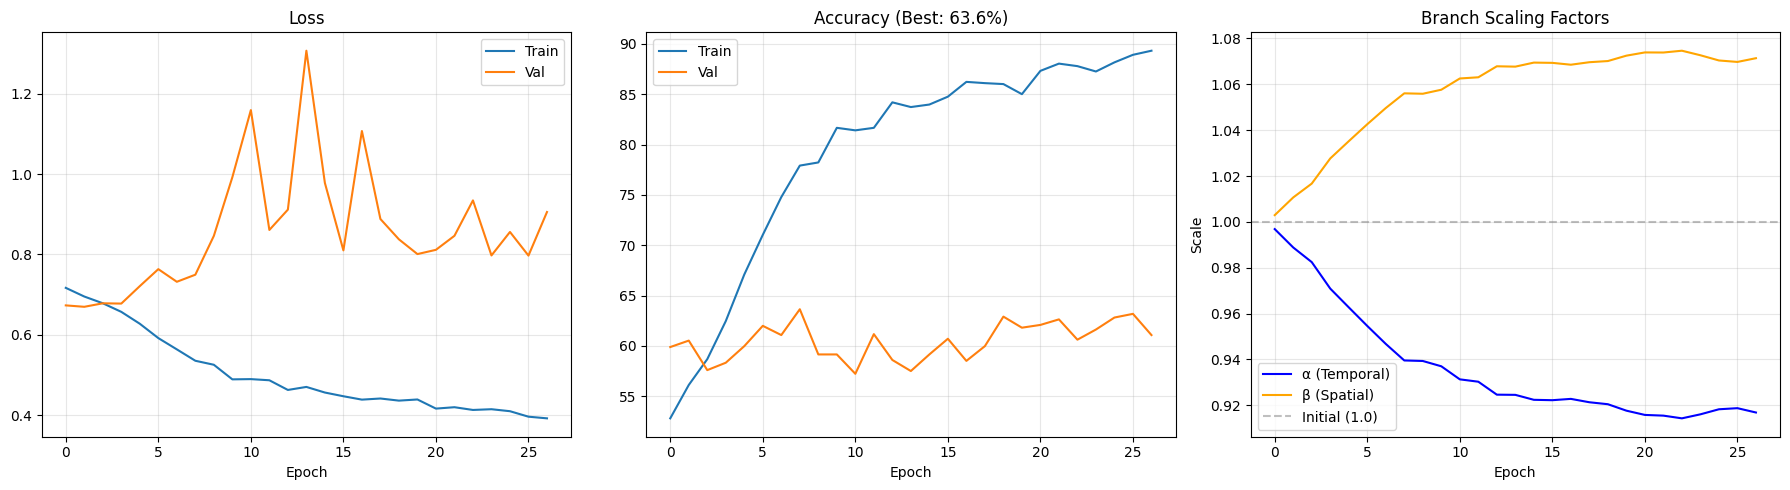

<Figure size 640x480 with 0 Axes>

In [13]:
# KAGGLE-OPTIMIZED: Train Final Model with Protocol Settings (v2.0)
import gc
import os
import json
import matplotlib.pyplot as plt

# ============================================================
# CHECK FOR EXISTING TRAINED MODEL
# ============================================================
KAGGLE_INPUT_DIR = '/kaggle/input/complete-path'
KAGGLE_WORKING_DIR = '/kaggle/working'
LOCAL_DIR = '.'

# Auto-detect environment and set paths
if os.path.exists(KAGGLE_INPUT_DIR):
    INPUT_DIR = KAGGLE_INPUT_DIR
    WORKING_DIR = KAGGLE_WORKING_DIR
else:
    INPUT_DIR = LOCAL_DIR
    WORKING_DIR = LOCAL_DIR

# Check input directory first (uploaded pre-trained model)
BEST_MODEL_PATH = os.path.join(INPUT_DIR, 'braingat_best.pth')
CONFIG_PATH = os.path.join(INPUT_DIR, 'training_config.json')

# Then check working directory (from current session)
WORKING_MODEL_PATH = os.path.join(WORKING_DIR, 'braingat_best.pth')
WORKING_CONFIG_PATH = os.path.join(WORKING_DIR, 'training_config.json')
CHECKPOINT_PATH = os.path.join(WORKING_DIR, 'braingat_checkpoint.pth')

# Check if training already completed
SKIP_TRAINING = False
if os.path.exists(BEST_MODEL_PATH) and os.path.exists(CONFIG_PATH):
    print("="*60)
    print("EXISTING TRAINED MODEL FOUND (from input)")
    print("="*60)
    print(f"  Model: {BEST_MODEL_PATH}")
    print(f"  Config: {CONFIG_PATH}")
    
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)
    print(f"  Config: {config}")
    
    # Load the model
    final_model = TemporalSpatialBrainGAT(
        in_channels=392,
        hidden_dim=config.get('hidden_dim', 32),
        temporal_dim=config.get('temporal_dim', 64),
        num_scales=3,
        heads=config.get('heads', 4),
        dropout=config.get('dropout', 0.5),
        num_classes=2
    ).to(device)
    final_model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    print("  Model loaded successfully.")
    
    # === v2.0: Print branch scales ===
    if hasattr(final_model, 'get_branch_scales'):
        scales = final_model.get_branch_scales()
        print(f"  Branch Scales: α={scales['temporal_scale (α)']:.4f}, β={scales['spatial_scale (β)']:.4f}")
    
    # Try to load history for plotting
    if os.path.exists(CHECKPOINT_PATH):
        ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
        history = ckpt.get('history', None)
        best_val_acc = ckpt.get('best_val_acc', 0.0)
        print(f"  Best Val Accuracy: {best_val_acc:.2f}%")
    else:
        history = None
        best_val_acc = 0.0
    
    SKIP_TRAINING = True
    print("\nSkipping training. Proceeding to evaluation.")
    print("="*60)

if not SKIP_TRAINING:
    # Memory cleanup
    if 'final_model' in globals():
        del final_model
    if 'optimizer' in globals():
        del optimizer
    gc.collect()
    torch.cuda.empty_cache()

    # Configuration (with label smoothing per protocol)
    config = {
        'lr': 5e-4,
        'hidden_dim': 32,
        'temporal_dim': 64,
        'dropout': 0.5,
        'weight_decay': 1e-4,
        'heads': 4,
        'label_smoothing': 0.1  # Protocol requirement
    }

    print("="*60)
    print("FINAL TRAINING (PROTOCOL SETTINGS v2.0)")
    print("="*60)
    print(f"Config: {json.dumps(config, indent=2)}")

    # Initialize model
    final_model = TemporalSpatialBrainGAT(
        in_channels=392,
        hidden_dim=config['hidden_dim'],
        temporal_dim=config['temporal_dim'],
        num_scales=3,
        heads=config['heads'],
        dropout=config['dropout'],
        num_classes=2
    ).to(device)

    params = sum(p.numel() for p in final_model.parameters())
    print(f"Parameters: {params:,}")
    
    # === v2.0: Print initial branch scales ===
    if hasattr(final_model, 'get_branch_scales'):
        scales = final_model.get_branch_scales()
        print(f"Initial Branch Scales: α={scales['temporal_scale (α)']:.4f}, β={scales['spatial_scale (β)']:.4f}")

    # Class weights
    num_ctrl = train_labels.count(0)
    num_asd = train_labels.count(1)
    w_ctrl = len(train_labels) / (2 * num_ctrl)
    w_asd = len(train_labels) / (2 * num_asd)
    class_weights = torch.tensor([w_ctrl, w_asd], dtype=torch.float).to(device)
    print(f"Class weights: Control={w_ctrl:.2f}, ASD={w_asd:.2f}")

    # Loss with label smoothing (PROTOCOL REQUIREMENT)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights, label_smoothing=config['label_smoothing'])
    print(f"Label smoothing: {config['label_smoothing']}")

    optimizer = torch.optim.Adam(final_model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    scaler = torch.amp.GradScaler('cuda')

    # Checkpointing paths (save to working directory)
    CHECKPOINT_PATH_LOCAL = os.path.join(WORKING_DIR, 'braingat_checkpoint.pth')
    BEST_MODEL_PATH_LOCAL = os.path.join(WORKING_DIR, 'braingat_best.pth')
    CONFIG_PATH_LOCAL = os.path.join(WORKING_DIR, 'training_config.json')

    # Save config
    with open(CONFIG_PATH_LOCAL, 'w') as f:
        json.dump({**config, 'window_length': WINDOW_LENGTH, 'stride': STRIDE}, f, indent=2)
    print(f"Saved config to {CONFIG_PATH_LOCAL}")

    # Training settings (PROTOCOL REQUIREMENTS)
    TOTAL_EPOCHS = 80
    PATIENCE = 20
    ACCUM_STEPS = 8

    # === v2.0: Added branch scale tracking to history ===
    history = {
        'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [],
        'temporal_scale': [], 'spatial_scale': []  # v2.0: Track branch importance
    }
    best_val_acc = 0.0
    best_val_loss = float('inf')
    patience_counter = 0
    start_epoch = 1

    # Resume if checkpoint exists
    if os.path.exists(CHECKPOINT_PATH_LOCAL):
        print(f"\nResuming from {CHECKPOINT_PATH_LOCAL}...")
        ckpt = torch.load(CHECKPOINT_PATH_LOCAL)
        final_model.load_state_dict(ckpt['model_state_dict'])
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        start_epoch = ckpt['epoch'] + 1
        best_val_acc = ckpt['best_val_acc']
        history = ckpt['history']
        # Ensure new keys exist for old checkpoints
        if 'temporal_scale' not in history:
            history['temporal_scale'] = []
        if 'spatial_scale' not in history:
            history['spatial_scale'] = []
        patience_counter = ckpt.get('patience_counter', 0)
        print(f"   Starting from epoch {start_epoch}, best acc: {best_val_acc:.2f}%")
    else:
        print("\nStarting fresh training...")

    print(f"\nConfig: {TOTAL_EPOCHS} epochs, patience={PATIENCE}, batch={BATCH_SIZE}x{ACCUM_STEPS}")
    print("="*60)

    try:
        for epoch in range(start_epoch, TOTAL_EPOCHS + 1):
            # TRAIN
            final_model.train()
            total_loss, correct, total = 0, 0, 0
            optimizer.zero_grad()
            
            for i, data in enumerate(train_loader):
                data = data.to(device)
                with torch.amp.autocast('cuda'):
                    out = final_model(data)
                    loss = criterion(out, data.y) / ACCUM_STEPS
                
                scaler.scale(loss).backward()
                
                if (i + 1) % ACCUM_STEPS == 0 or (i + 1) == len(train_loader):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                
                total_loss += loss.item() * ACCUM_STEPS * data.num_graphs
                correct += (out.argmax(dim=1) == data.y).sum().item()
                total += data.num_graphs
            
            train_loss = total_loss / total
            train_acc = 100.0 * correct / total
            
            # VALIDATE
            final_model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    with torch.amp.autocast('cuda'):
                        out = final_model(data)
                        loss = criterion(out, data.y)
                    if not torch.isnan(loss):
                        val_loss += loss.item() * data.num_graphs
                    val_correct += (out.argmax(dim=1) == data.y).sum().item()
                    val_total += data.num_graphs
            
            val_loss = val_loss / val_total if val_total > 0 else float('inf')
            val_acc = 100.0 * val_correct / val_total if val_total > 0 else 0.0
            
            scheduler.step(val_loss)
            
            # === v2.0: Get current branch scales ===
            if hasattr(final_model, 'get_branch_scales'):
                scales = final_model.get_branch_scales()
                alpha = scales['temporal_scale (α)']
                beta = scales['spatial_scale (β)']
            else:
                alpha, beta = 1.0, 1.0
            
            # History (including branch scales)
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            history['temporal_scale'].append(alpha)
            history['spatial_scale'].append(beta)
            
            # Best model check
            is_best = val_acc > best_val_acc
            if is_best:
                best_val_acc = val_acc
                torch.save(final_model.state_dict(), BEST_MODEL_PATH_LOCAL)
                patience_counter = 0
            
            # Early stopping (loss-based)
            if val_loss < best_val_loss - 0.001:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Save checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': final_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc,
                'history': history,
                'patience_counter': patience_counter
            }, CHECKPOINT_PATH_LOCAL)
            
            # Print progress (including branch scales every 10 epochs)
            if epoch % 5 == 0 or is_best:
                status = "* BEST" if is_best else f"(p:{patience_counter}/{PATIENCE})"
                print(f"E{epoch:03d} | Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.1e} {status}")
            
            # === v2.0: Print branch scales every 10 epochs to monitor temporal branch importance ===
            if epoch % 10 == 0:
                print(f"       Branch Scales: α(temporal)={alpha:.4f}, β(spatial)={beta:.4f}")
                if alpha < 0.1:
                    print(f"       ⚠️  WARNING: Temporal scale is low. Consider checking data preprocessing or window length.")
            
            if patience_counter >= PATIENCE:
                print(f"\nEarly stopping at epoch {epoch}")
                break
            
            if epoch % 20 == 0:
                torch.cuda.empty_cache()

    except KeyboardInterrupt:
        print("\nInterrupted - checkpoint saved!")

    print("\n" + "="*60)
    print("TRAINING COMPLETE")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    
    # === v2.0: Print final branch scales ===
    if hasattr(final_model, 'get_branch_scales'):
        scales = final_model.get_branch_scales()
        print(f"Final Branch Scales: α(temporal)={scales['temporal_scale (α)']:.4f}, β(spatial)={scales['spatial_scale (β)']:.4f}")
        if scales['temporal_scale (α)'] < 0.1:
            print("⚠️  Temporal branch has low weight - consider:")
            print("   1. Enable EXCLUDE_PHASE_SYNC_FROM_EDGES = True for ablation")
            print("   2. Check if window length (80) captures meaningful dynamics")
            print("   3. Verify temporal preprocessing is correct")
    print("="*60)

    # Load best model
    if os.path.exists(BEST_MODEL_PATH_LOCAL):
        final_model.load_state_dict(torch.load(BEST_MODEL_PATH_LOCAL))
        print(f"Loaded best model from {BEST_MODEL_PATH_LOCAL}")

# Plot training curves (works for both loaded and fresh training)
if history is not None and len(history.get('train_loss', [])) > 0:
    # === v2.0: Added branch scale plot ===
    has_scales = 'temporal_scale' in history and len(history['temporal_scale']) > 0
    n_plots = 3 if has_scales else 2
    
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Train')
    axes[0].plot(history['val_loss'], label='Val')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes[1].plot(history['train_acc'], label='Train')
    axes[1].plot(history['val_acc'], label='Val')
    axes[1].set_title(f'Accuracy (Best: {best_val_acc:.1f}%)')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Branch scales plot (v2.0)
    if has_scales:
        axes[2].plot(history['temporal_scale'], label='α (Temporal)', color='blue')
        axes[2].plot(history['spatial_scale'], label='β (Spatial)', color='orange')
        axes[2].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Initial (1.0)')
        axes[2].set_title('Branch Scaling Factors')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Scale')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('training_curves.png', dpi=150)
else:
    print("No training history available for plotting.")

In [14]:
# Save All Outputs
import shutil
import os
import json

print("="*60)
print("SAVING ALL OUTPUTS")
print("="*60)

# Determine directories
KAGGLE_WORKING = '/kaggle/working'
KAGGLE_INPUT = '/kaggle/input/complete-path'
USE_KAGGLE = os.path.exists(KAGGLE_WORKING)

# List of output files to check
output_files = [
    'braingat_best.pth',
    'braingat_checkpoint.pth',
    'training_config.json',
    'subject_splits.json',
    'subject_level_results.json',
    'training_curves.png',
    'sweep_results.json',
    'ablation_results.json'
]

# Check files in working directory (no need to copy, just verify)
saved_count = 0
for f in output_files:
    if USE_KAGGLE:
        # On Kaggle: check both input and working directories
        working_path = os.path.join(KAGGLE_WORKING, f)
        input_path = os.path.join(KAGGLE_INPUT, f) if os.path.exists(KAGGLE_INPUT) else None
        
        if os.path.exists(working_path):
            print(f"  [OK] {f} (in working)")
            saved_count += 1
        elif input_path and os.path.exists(input_path):
            print(f"  [OK] {f} (in input)")
            saved_count += 1
        else:
            print(f"  [--] {f} not found")
    else:
        # Local: check current directory
        if os.path.exists(f):
            print(f"  [OK] {f} (local)")
            saved_count += 1
        else:
            print(f"  [--] {f} not found")

print(f"\nSaved {saved_count}/{len(output_files)} files")

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)

# Print summary based on available results
if 'config' in dir():
    print(f"Window params: length={WINDOW_LENGTH}, stride={STRIDE}")
    print(f"Config: {json.dumps(config, indent=2)}")

if 'best_val_acc' in dir():
    print(f"\nWindow-level metrics:")
    print(f"  Best validation accuracy: {best_val_acc:.2f}%")

if 'val_results' in dir() and 'test_results' in dir():
    print(f"\nSubject-level metrics:")
    print(f"  Validation accuracy: {val_results['accuracy']:.2f}%")
    print(f"  Validation AUC: {val_results['auc']:.3f}")
    print(f"  Test accuracy: {test_results['accuracy']:.2f}%")
    print(f"  Test AUC: {test_results['auc']:.3f}")

print("\nPipeline complete.")

SAVING ALL OUTPUTS
  [OK] braingat_best.pth (in input)
  [--] braingat_checkpoint.pth not found
  [OK] training_config.json (in input)
  [OK] subject_splits.json (in working)
  [OK] subject_level_results.json (in working)
  [--] training_curves.png not found
  [OK] sweep_results.json (in working)
  [OK] ablation_results.json (in working)

Saved 6/8 files

RESULTS SUMMARY
Window params: length=80, stride=40
Config: {
  "lr": 0.0005,
  "hidden_dim": 32,
  "temporal_dim": 64,
  "dropout": 0.5,
  "weight_decay": 0.0001,
  "heads": 4,
  "label_smoothing": 0.1,
  "window_length": 80,
  "stride": 40
}

Window-level metrics:
  Best validation accuracy: 0.00%

Pipeline complete.


In [15]:
# Subject-Level Evaluation (CRITICAL - Protocol Requirement)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
import numpy as np

def evaluate_subject_level(model, loader, subject_ids, subject_data, set_name="Test"):
    """
    Aggregate window predictions to subject level.
    Returns subject-level metrics (not window-level).
    """
    model.eval()
    
    # Collect window-level predictions
    window_preds = []
    window_probs = []
    window_labels = []
    window_subjects = []
    
    with torch.no_grad():
        for batch_idx, data in enumerate(loader):
            data = data.to(device)
            with torch.amp.autocast('cuda'):
                out = model(data)
            
            probs = torch.softmax(out, dim=1)
            preds = out.argmax(dim=1)
            
            # Get subject IDs for this batch
            start_idx = batch_idx * BATCH_SIZE
            end_idx = start_idx + data.num_graphs
            batch_subjects = subject_ids[start_idx:end_idx]
            
            window_preds.extend(preds.cpu().numpy())
            window_probs.extend(probs[:, 1].cpu().numpy())  # P(ASD)
            window_labels.extend(data.y.cpu().numpy())
            window_subjects.extend(batch_subjects)
    
    # Aggregate to subject level
    subject_preds = {}
    subject_probs = {}
    subject_labels = {}
    
    for subj, pred, prob, label in zip(window_subjects, window_preds, window_probs, window_labels):
        if subj not in subject_preds:
            subject_preds[subj] = []
            subject_probs[subj] = []
            subject_labels[subj] = label
        subject_preds[subj].append(pred)
        subject_probs[subj].append(prob)
    
    # Compute subject-level predictions (mean probability)
    final_subjects = list(subject_preds.keys())
    final_labels = [subject_labels[s] for s in final_subjects]
    final_probs = [np.mean(subject_probs[s]) for s in final_subjects]
    final_preds = [1 if p > 0.5 else 0 for p in final_probs]
    
    # Metrics
    acc = accuracy_score(final_labels, final_preds) * 100
    try:
        auc = roc_auc_score(final_labels, final_probs)
    except:
        auc = 0.5
    
    cm = confusion_matrix(final_labels, final_preds)
    report = classification_report(final_labels, final_preds, target_names=['Control', 'ASD'], digits=3)
    
    print(f"\n{'='*60}")
    print(f"SUBJECT-LEVEL RESULTS: {set_name}")
    print(f"{'='*60}")
    print(f"Subjects evaluated: {len(final_subjects)}")
    print(f"Subject-Level Accuracy: {acc:.2f}%")
    print(f"Subject-Level AUC: {auc:.3f}")
    print(f"\nConfusion Matrix:")
    print(f"              Pred Control  Pred ASD")
    print(f"True Control      {cm[0,0]:4d}        {cm[0,1]:4d}")
    print(f"True ASD          {cm[1,0]:4d}        {cm[1,1]:4d}")
    print(f"\nClassification Report:")
    print(report)
    
    return {
        'accuracy': acc,
        'auc': auc,
        'confusion_matrix': cm,
        'subjects': final_subjects,
        'predictions': final_preds,
        'probabilities': final_probs,
        'labels': final_labels
    }

# Evaluate on validation and test sets
print("\n" + "="*60)
print("SUBJECT-LEVEL EVALUATION")
print("="*60)

val_results = evaluate_subject_level(final_model, val_loader, val_subject_ids, subject_data, "Validation")
test_results = evaluate_subject_level(final_model, test_loader, test_subject_ids, subject_data, "Test")

# Save results
results_summary = {
    'validation': {'accuracy': val_results['accuracy'], 'auc': val_results['auc']},
    'test': {'accuracy': test_results['accuracy'], 'auc': test_results['auc']}
}
with open('subject_level_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"\nSaved results to subject_level_results.json")


SUBJECT-LEVEL EVALUATION

SUBJECT-LEVEL RESULTS: Validation
Subjects evaluated: 177
Subject-Level Accuracy: 65.54%
Subject-Level AUC: 0.679

Confusion Matrix:
              Pred Control  Pred ASD
True Control        59          26
True ASD            35          57

Classification Report:
              precision    recall  f1-score   support

     Control      0.628     0.694     0.659        85
         ASD      0.687     0.620     0.651        92

    accuracy                          0.655       177
   macro avg      0.657     0.657     0.655       177
weighted avg      0.658     0.655     0.655       177


SUBJECT-LEVEL RESULTS: Test
Subjects evaluated: 178
Subject-Level Accuracy: 65.17%
Subject-Level AUC: 0.735

Confusion Matrix:
              Pred Control  Pred ASD
True Control        61          25
True ASD            37          55

Classification Report:
              precision    recall  f1-score   support

     Control      0.622     0.709     0.663        86
         ASD  

In [16]:
# ============================================================
# POST-TRAINING IMPORTS & MODEL LOADING (Run this cell first!)
# ============================================================
# Use this cell when resuming a Kaggle session to load the trained model

import os
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader as PyGDataLoader
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from pathlib import Path

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ============================================================
# KAGGLE PATHS (change these if running locally)
# ============================================================
KAGGLE_INPUT_DIR = '/kaggle/input/complete-path'
KAGGLE_WORKING_DIR = '/kaggle/working'
LOCAL_DIR = '.'

# Auto-detect environment
if os.path.exists(KAGGLE_INPUT_DIR):
    INPUT_DIR = KAGGLE_INPUT_DIR
    WORKING_DIR = KAGGLE_WORKING_DIR
    print(f"Running on Kaggle - loading from {INPUT_DIR}")
else:
    INPUT_DIR = LOCAL_DIR
    WORKING_DIR = LOCAL_DIR
    print(f"Running locally - loading from {INPUT_DIR}")

# File paths (load pre-trained from input, save new results to working)
BEST_MODEL_PATH = os.path.join(INPUT_DIR, 'braingat_best.pth')
CHECKPOINT_PATH = os.path.join(INPUT_DIR, 'braingat_checkpoint.pth')
CONFIG_PATH = os.path.join(INPUT_DIR, 'training_config.json')
SPLITS_PATH = os.path.join(INPUT_DIR, 'subject_splits.json')
CACHE_PATH = os.path.join(WORKING_DIR, 'subject_data_cache.pkl')
RESULTS_PATH = os.path.join(WORKING_DIR, 'subject_level_results.json')

# ============================================================
# LOAD CONFIGURATION
# ============================================================
if os.path.exists(CONFIG_PATH):
    with open(CONFIG_PATH, 'r') as f:
        config = json.load(f)
    print(f"Loaded config: {config}")
else:
    # Default config
    config = {
        'lr': 5e-4, 'hidden_dim': 32, 'temporal_dim': 64,
        'dropout': 0.5, 'weight_decay': 1e-4, 'heads': 4,
        'label_smoothing': 0.1, 'window_length': 80, 'stride': 40
    }
    print(f"WARNING: Config not found, using defaults")

WINDOW_LENGTH = config.get('window_length', 80)
STRIDE = config.get('stride', 40)
BATCH_SIZE = 4
K_VALUES = [10, 30, 100]

# ============================================================
# MODEL ARCHITECTURE (must match training)
# ============================================================
class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, x):
        Q, K, V = self.query(x), self.key(x), self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(Q.size(-1))
        return torch.matmul(F.softmax(scores, dim=-1), V)

class TemporalBranch(nn.Module):
    def __init__(self, input_time_len=80, hidden_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(1, hidden_dim, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.temporal_attn = TemporalAttention(hidden_dim)
        self.pool = nn.AdaptiveAvgPool1d(1)
    def forward(self, timeseries, batch):
        x = timeseries.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.transpose(1, 2)
        x = self.temporal_attn(x)
        x = x.transpose(1, 2)
        x = self.pool(x).squeeze(-1)
        return global_mean_pool(x, batch)

class MultiHeadGATLayerWithEdgeFeats(nn.Module):
    def __init__(self, in_channels, out_channels, heads=4, dropout=0.3, concat=True):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=heads, dropout=dropout, concat=concat, edge_dim=4)
        self.bn = nn.BatchNorm1d(out_channels * heads if concat else out_channels)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, edge_index, edge_attr):
        x = self.gat(x, edge_index, edge_attr=edge_attr)
        return self.dropout(F.elu(self.bn(x)))

class MultiScaleSpatialBranch(nn.Module):
    def __init__(self, in_channels, hidden_dim=32, num_scales=3, heads=4, dropout=0.5):
        super().__init__()
        self.num_scales = num_scales
        self.gats = nn.ModuleList([
            nn.ModuleList([
                MultiHeadGATLayerWithEdgeFeats(in_channels, hidden_dim, heads, dropout, concat=True),
                MultiHeadGATLayerWithEdgeFeats(hidden_dim * heads, hidden_dim, heads, dropout, concat=False)
            ]) for _ in range(num_scales)
        ])
    def forward(self, x, edge_indices, edge_attrs, batch):
        scale_features = []
        for i in range(self.num_scales):
            h = x
            for gat_layer in self.gats[i]:
                h = gat_layer(h, edge_indices[i], edge_attrs[i])
            h_mean, h_max = global_mean_pool(h, batch), global_max_pool(h, batch)
            scale_features.append(torch.cat([h_mean, h_max], dim=-1))
        return torch.cat(scale_features, dim=-1)

class TemporalSpatialBrainGAT(nn.Module):
    def __init__(self, in_channels, hidden_dim=32, temporal_dim=64, num_scales=3, heads=4, dropout=0.5, num_classes=2):
        super().__init__()
        self.num_scales = num_scales
        self.temporal_branch = TemporalBranch(input_time_len=80, hidden_dim=temporal_dim)
        self.spatial_branch = MultiScaleSpatialBranch(in_channels, hidden_dim, num_scales, heads, dropout)
        total_dim = num_scales * hidden_dim * 2 + temporal_dim
        self.classifier = nn.Sequential(
            nn.Linear(total_dim, hidden_dim * 4), nn.BatchNorm1d(hidden_dim * 4), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(hidden_dim * 4, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(hidden_dim * 2, num_classes)
        )
    def forward(self, data):
        x, timeseries = data.x, data.timeseries
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        edge_indices = [getattr(data, f'edge_index_{i}') for i in range(self.num_scales)]
        edge_attrs = [getattr(data, f'edge_attr_{i}') for i in range(self.num_scales)]
        temporal_feats = self.temporal_branch(timeseries, batch)
        spatial_feats = self.spatial_branch(x, edge_indices, edge_attrs, batch)
        return self.classifier(torch.cat([temporal_feats, spatial_feats], dim=-1))

# ============================================================
# LOAD TRAINED MODEL
# ============================================================
model = TemporalSpatialBrainGAT(
    in_channels=392,
    hidden_dim=config.get('hidden_dim', 32),
    temporal_dim=config.get('temporal_dim', 64),
    num_scales=3,
    heads=config.get('heads', 4),
    dropout=config.get('dropout', 0.5),
    num_classes=2
).to(device)

if os.path.exists(BEST_MODEL_PATH):
    model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))
    print(f"Loaded best model from {BEST_MODEL_PATH}")
elif os.path.exists(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    print(f"Loaded checkpoint (epoch {ckpt['epoch']}) from {CHECKPOINT_PATH}")
else:
    print("ERROR: No trained model found. Run training first.")

# ============================================================
# LOAD SUBJECT SPLITS
# ============================================================
if os.path.exists(SPLITS_PATH):
    with open(SPLITS_PATH, 'r') as f:
        split_info = json.load(f)
    train_subjects = split_info['train_subjects']
    val_subjects = split_info['val_subjects']
    test_subjects = split_info['test_subjects']
    print(f"Loaded splits: {len(train_subjects)} train, {len(val_subjects)} val, {len(test_subjects)} test")
else:
    print("WARNING: Subject splits not found")

# ============================================================
# LOAD PREVIOUS RESULTS (if available)
# ============================================================
if os.path.exists(RESULTS_PATH):
    with open(RESULTS_PATH, 'r') as f:
        prev_results = json.load(f)
    print(f"\nPrevious Results:")
    print(f"   Val Accuracy: {prev_results['validation']['accuracy']:.2f}%")
    print(f"   Val AUC: {prev_results['validation']['auc']:.3f}")
    print(f"   Test Accuracy: {prev_results['test']['accuracy']:.2f}%")
    print(f"   Test AUC: {prev_results['test']['auc']:.3f}")

print("\nPost-training setup complete. Model ready for inference.")


Device: cuda
Running on Kaggle - loading from /kaggle/input/complete-path
Loaded config: {'lr': 0.0005, 'hidden_dim': 32, 'temporal_dim': 64, 'dropout': 0.5, 'weight_decay': 0.0001, 'heads': 4, 'label_smoothing': 0.1, 'window_length': 80, 'stride': 40}
Loaded best model from /kaggle/input/complete-path/braingat_best.pth
Loaded splits: 531 train, 177 val, 178 test

Previous Results:
   Val Accuracy: 65.54%
   Val AUC: 0.679
   Test Accuracy: 65.17%
   Test AUC: 0.735

Post-training setup complete. Model ready for inference.


## Hyperparameter Optimization Strategy

### Phase 2: Sanity Sweep (Small Grid)

Before exploring architectural changes, we establish a strong baseline through a focused hyperparameter sweep. This is not an exhaustive grid search but a sanity check on key regularization parameters.

| Parameter | Values | Rationale |
|-----------|--------|-----------|
| Learning rate | {1e-3, 3e-4} | Bracket around default 5e-4 |
| Weight decay | {1e-4, 5e-4} | L2 regularization strength |
| Label smoothing | {0.05, 0.1} | Calibration vs confidence |
| Dropout | {0.3, 0.5} | Regularization intensity |

**Total configurations**: 2 x 2 x 2 x 2 = 16 runs

**Estimated time**: ~40 min per run x 16 = ~10-11 hours (fits in Kaggle session)

### Phase 3: Architectural Hypotheses (After Phase 2)

Only after establishing optimal regularization:

1. **Window length sensitivity**: {60, 80, 100} TR
   - Shorter windows: More samples, less temporal context
   - Longer windows: Richer dynamics, fewer samples

2. **Stride sensitivity**: {20, 40} TR
   - stride=20: 75% overlap, 4x more windows
   - stride=40: 50% overlap (current baseline)

3. **Temporal module ablation**:
   - Full model (temporal + spatial)
   - Spatial only (remove temporal branch)
   - Temporal only (remove GAT)

4. **Multi-scale ablation**:
   - Full hierarchy: k={10, 30, 100}
   - Single scale: k=30 only
   - Two scales: k={10, 100}

In [17]:
# Optional helper: ONLY use this if you explicitly want to force re-running Phase 2.
# By default (FORCE_RESUME_SWEEP=0), this does nothing so you can safely "Run all".

import os

FORCE_RESUME_SWEEP = int(os.environ.get('FORCE_RESUME_SWEEP', '0'))

if FORCE_RESUME_SWEEP and os.path.exists('sweep_results.json'):
    os.rename('sweep_results.json', 'sweep_results_incomplete.json')
    print("Renamed sweep_results.json -> sweep_results_incomplete.json (forced sweep resume)")
else:
    print("Sweep resume not forced; leaving sweep_results.json intact.")

Sweep resume not forced; leaving sweep_results.json intact.


In [18]:
# ============================================================
# PHASE 2: HYPERPARAMETER SANITY SWEEP
# ============================================================
# Small grid search over regularization parameters
# 16 configurations, ~40 min each = ~10-11 hours total

import os
import gc
import itertools
import json
import time
from datetime import datetime
from tqdm import tqdm

# ============================================================
# CHECK FOR EXISTING SWEEP RESULTS
# ============================================================
KAGGLE_DIR = '/kaggle/working'
LOCAL_DIR = '.'
BASE_DIR = KAGGLE_DIR if os.path.exists(KAGGLE_DIR) else LOCAL_DIR

SWEEP_RESULTS_PATH = os.path.join(BASE_DIR, 'sweep_results.json')

# Define search space first to know total configs
PARAM_GRID = {
    'lr': [1e-3, 3e-4],
    'weight_decay': [1e-4, 5e-4],
    'label_smoothing': [0.05, 0.1],
    'dropout': [0.3, 0.5]
}
param_names = list(PARAM_GRID.keys())
param_values = list(PARAM_GRID.values())
all_configs = list(itertools.product(*param_values))
TOTAL_CONFIGS = len(all_configs)

SKIP_SWEEP = False
if os.path.exists(SWEEP_RESULTS_PATH):
    print("="*70)
    print("EXISTING SWEEP RESULTS FOUND")
    print("="*70)
    with open(SWEEP_RESULTS_PATH, 'r') as f:
        sweep_data = json.load(f)
    
    sweep_results = sweep_data['results']
    best_config = sweep_data['best_config']
    best_overall_acc = sweep_data['best_val_acc']
    
    print(f"Configurations tested: {len(sweep_results)}/{TOTAL_CONFIGS}")
    print(f"Best Val Accuracy: {best_overall_acc:.2f}%")
    print(f"Best Config:")
    print(f"  lr: {best_config['lr']}")
    print(f"  weight_decay: {best_config['weight_decay']}")
    print(f"  label_smoothing: {best_config['label_smoothing']}")
    print(f"  dropout: {best_config['dropout']}")
    
    # Show all results sorted
    import pandas as pd
    df = pd.DataFrame(sweep_results).sort_values('best_val_acc', ascending=False)
    print("\nAll results (sorted by val acc):")
    print(df.to_string(index=False))
    
    # Check if sweep is complete
    if len(sweep_results) >= TOTAL_CONFIGS:
        SKIP_SWEEP = True
        print("\nSweep complete! All configurations tested.")
        print("="*70)
    else:
        print(f"\nSweep incomplete! Resuming from config {len(sweep_results)+1}...")
        print("="*70)
        # Treat as partial results
        completed_indices = {r['config_idx'] for r in sweep_results}
        sweep_start_time = time.time() - sweep_data.get('total_time_hours', 0) * 3600

if not SKIP_SWEEP:
    torch.cuda.empty_cache()
    gc.collect()

    # Fixed parameters
    FIXED_PARAMS = {
        'hidden_dim': 32,
        'temporal_dim': 64,
        'heads': 4,
        'epochs': 60,
        'patience': 20,
        'batch_size': 4,
        'accum_steps': 8
    }

    print("="*70)
    print("PHASE 2: HYPERPARAMETER SANITY SWEEP")
    print("="*70)
    print(f"Search space: {PARAM_GRID}")
    print(f"Fixed params: hidden_dim={FIXED_PARAMS['hidden_dim']}, temporal_dim={FIXED_PARAMS['temporal_dim']}")
    print(f"Total configurations: {len(all_configs)}")
    print(f"Epochs per config: {FIXED_PARAMS['epochs']} (patience={FIXED_PARAMS['patience']})")
    print("="*70)

    # Results storage - check if resuming from incomplete sweep_results.json
    PARTIAL_RESULTS_PATH = os.path.join(BASE_DIR, 'sweep_partial.json')
    if 'completed_indices' not in dir():
        # Not resuming from incomplete sweep_results.json, check for partial file
        if os.path.exists(PARTIAL_RESULTS_PATH):
            print("\nFound partial results from previous run. Resuming...")
            with open(PARTIAL_RESULTS_PATH, 'r') as f:
                partial_data = json.load(f)
            sweep_results = partial_data['results']
            best_overall_acc = partial_data.get('best_val_acc', 0.0)
            best_config = partial_data.get('best_config', None)
            completed_indices = {r['config_idx'] for r in sweep_results}
            print(f"Completed {len(completed_indices)}/{len(all_configs)} configs. Resuming from config {len(completed_indices)+1}")
            sweep_start_time = time.time() - partial_data.get('elapsed_time', 0)
        else:
            sweep_results = []
            best_overall_acc = 0.0
            best_config = None
            completed_indices = set()
            sweep_start_time = time.time()

    # Class weights (compute once)
    num_ctrl = sum(1 for s in train_subjects if subject_data[s]['label'] == 0)
    num_asd = sum(1 for s in train_subjects if subject_data[s]['label'] == 1)
    total_samples = num_ctrl + num_asd
    w_ctrl = total_samples / (2 * num_ctrl)
    w_asd = total_samples / (2 * num_asd)
    class_weights = torch.tensor([w_ctrl, w_asd], dtype=torch.float).to(device)

    for config_idx, config_values in tqdm(enumerate(all_configs), total=len(all_configs), desc="Sweep Progress", position=0):
        # Skip if already completed
        if config_idx in completed_indices:
            tqdm.write(f"[{config_idx+1}/{len(all_configs)}] Skipping (already completed)")
            continue
        
        # Build config dict
        config = dict(zip(param_names, config_values))
        config.update(FIXED_PARAMS)
        
        tqdm.write(f"\n[{config_idx+1}/{len(all_configs)}] Config: lr={config['lr']:.0e}, wd={config['weight_decay']:.0e}, "
                   f"ls={config['label_smoothing']}, do={config['dropout']}")
        
        # Clean up previous model
        if 'model' in dir():
            del model
        torch.cuda.empty_cache()
        gc.collect()
        
        # Initialize model
        model = TemporalSpatialBrainGAT(
            in_channels=392,
            hidden_dim=config['hidden_dim'],
            temporal_dim=config['temporal_dim'],
            num_scales=3,
            heads=config['heads'],
            dropout=config['dropout'],
            num_classes=2
        ).to(device)
        
        criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=config['label_smoothing'])
        optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=1e-6)
        scaler = torch.amp.GradScaler('cuda')
        # Training loop
        best_val_acc = 0.0
        patience_counter = 0
        config_start_time = time.time()
        
        pbar = tqdm(range(1, config['epochs'] + 1), desc=f"Config {config_idx+1}/{len(all_configs)}", position=1, leave=False)
        for epoch in pbar:
            # Train
            model.train()
            correct, total = 0, 0
            optimizer.zero_grad()
            
            for i, data in enumerate(train_loader):
                data = data.to(device)
                with torch.amp.autocast('cuda'):
                    out = model(data)
                    loss = criterion(out, data.y) / config['accum_steps']
                
                scaler.scale(loss).backward()
                
                if (i + 1) % config['accum_steps'] == 0 or (i + 1) == len(train_loader):
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                
                correct += (out.argmax(dim=1) == data.y).sum().item()
                total += data.num_graphs
            
            train_acc = 100.0 * correct / total
            
            # Validate
            model.eval()
            val_correct, val_total = 0, 0
            with torch.no_grad():
                for data in val_loader:
                    data = data.to(device)
                    with torch.amp.autocast('cuda'):
                        out = model(data)
                    val_correct += (out.argmax(dim=1) == data.y).sum().item()
                    val_total += data.num_graphs
            val_acc = 100.0 * val_correct / val_total
            scheduler.step()
            
            # Update progress bar
            pbar.set_postfix({'train_acc': f'{train_acc:.1f}%', 'val_acc': f'{val_acc:.1f}%', 'best': f'{best_val_acc:.1f}%', 'patience': f'{patience_counter}/{config["patience"]}'}, refresh=True)
            
            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                # Save best model for this config
                torch.save(model.state_dict(), f'sweep_best_{config_idx}.pth')
            else:
                patience_counter += 1
            
            if patience_counter >= config['patience']:
                pbar.close()
                break
    
        config_time = time.time() - config_start_time
        
        # Record results
        result = {
            'config_idx': config_idx,
            'lr': config['lr'],
            'weight_decay': config['weight_decay'],
            'label_smoothing': config['label_smoothing'],
            'dropout': config['dropout'],
            'best_val_acc': best_val_acc,
            'final_epoch': epoch,
            'time_minutes': config_time / 60
        }
        sweep_results.append(result)
        
        tqdm.write(f"    Best Val Acc: {best_val_acc:.2f}% (epoch {epoch}, {config_time/60:.1f} min)")
        
        # Track overall best
        if best_val_acc > best_overall_acc:
            best_overall_acc = best_val_acc
            best_config = config.copy()
            best_config_idx = config_idx
            tqdm.write(f"    ** NEW OVERALL BEST **")
        
        # Save partial results after each config (resume capability)
        partial_output = {
            'results': sweep_results,
            'best_config': best_config,
            'best_val_acc': best_overall_acc,
            'elapsed_time': time.time() - sweep_start_time
        }
        with open(PARTIAL_RESULTS_PATH, 'w') as f:
            json.dump(partial_output, f, indent=2)

    total_time = time.time() - sweep_start_time

    # Summary
    print("\n" + "="*70)
    print("SWEEP COMPLETE")
    print("="*70)
    print(f"Total time: {total_time/3600:.2f} hours")
    print(f"\nBest configuration (Val Acc: {best_overall_acc:.2f}%):")
    print(f"  lr: {best_config['lr']}")
    print(f"  weight_decay: {best_config['weight_decay']}")
    print(f"  label_smoothing: {best_config['label_smoothing']}")
    print(f"  dropout: {best_config['dropout']}")

    # Save results
    import pandas as pd
    sweep_results_df = pd.DataFrame(sweep_results)
    sweep_results_df = sweep_results_df.sort_values('best_val_acc', ascending=False)
    print("\nAll results (sorted by val acc):")
    print(sweep_results_df.to_string(index=False))

    # Save to file (both local and Kaggle)
    sweep_output = {
        'results': sweep_results,
        'best_config': best_config,
        'best_val_acc': best_overall_acc,
        'total_time_hours': total_time / 3600
    }
    print("\nSaved to sweep_results.json")
    with open('sweep_results.json', 'w') as f:
        json.dump(sweep_output, f, indent=2)
    print("\nSaved to sweep_results.json")
    
    # Also save to Kaggle if available
    if os.path.exists('/kaggle/working'):
        with open('/kaggle/working/sweep_results.json', 'w') as f:
            json.dump(sweep_output, f, indent=2)
        print("Saved to /kaggle/working/sweep_results.json")
    
    # Clean up partial results file
    if os.path.exists(PARTIAL_RESULTS_PATH):
        os.remove(PARTIAL_RESULTS_PATH)
        print("Removed partial results file (sweep complete)")

EXISTING SWEEP RESULTS FOUND
Configurations tested: 16/16
Best Val Accuracy: 64.57%
Best Config:
  lr: 0.001
  weight_decay: 0.0001
  label_smoothing: 0.05
  dropout: 0.3

All results (sorted by val acc):
 config_idx     lr  weight_decay  label_smoothing  dropout  best_val_acc  final_epoch  time_minutes
          0 0.0010        0.0001             0.05      0.3     64.569536           47     52.284160
         14 0.0003        0.0005             0.10      0.3     64.072848           43     47.366181
         12 0.0003        0.0005             0.05      0.3     63.410596           56     62.015422
         10 0.0003        0.0001             0.10      0.3     62.086093           41     45.340084
          6 0.0010        0.0005             0.10      0.3     61.920530           28     30.759000
          9 0.0003        0.0001             0.05      0.5     61.092715           50     54.711221
         15 0.0003        0.0005             0.10      0.5     61.092715           45     49.63

## Phase 3: Architectural Ablations

Run these experiments AFTER Phase 2 is complete and the optimal regularization parameters are established. Each ablation isolates one architectural decision.

In [19]:
# ============================================================
# PHASE 3: ARCHITECTURAL ABLATIONS
# ============================================================
# Run after Phase 2 sweep is complete
# Uses best hyperparameters from sweep

import os
import gc
import json
import time

# ============================================================
# HELPERS (resume-safe + incremental saving)
# ============================================================
KAGGLE_DIR = '/kaggle/working'
LOCAL_DIR = '.'
BASE_DIR = KAGGLE_DIR if os.path.exists(KAGGLE_DIR) else LOCAL_DIR
ABLATION_RESULTS_PATH = os.path.join(BASE_DIR, 'ablation_results.json')

def _coerce_key_int_str(d: dict, key: str):
    # Accept both int and str keys from older runs
    if key in d:
        return d[key]
    try:
        k_int = int(key)
        if k_int in d:
            return d[k_int]
    except Exception:
        pass
    return None

def save_ablation_results(results: dict):
    # Always save to BASE_DIR and also to local working dir if different
    with open(os.path.join(BASE_DIR, 'ablation_results.json'), 'w') as f:
        json.dump(results, f, indent=2)
    if BASE_DIR != LOCAL_DIR:
        with open(os.path.join(LOCAL_DIR, 'ablation_results.json'), 'w') as f:
            json.dump(results, f, indent=2)

def require_var(name: str):
    if name not in globals():
        raise RuntimeError(f"Required variable '{name}' is missing. Run the earlier setup cells before Phase 3.")

for _v in [
    'torch', 'nn', 'device',
    'TemporalSpatialBrainGAT', 'TemporalBranch',
    'train_subjects', 'val_subjects', 'subject_data',
    'extract_temporal_windows', 'graph_from_timeseries_enhanced', 'K_VALUES',
    'PyGDataLoader', 'BATCH_SIZE', 'class_weights',
    'train_loader', 'val_loader'
]:
    require_var(_v)

# ============================================================
# LOAD/RESUME EXISTING RESULTS (do NOT skip; resume missing)
# ============================================================
ablation_results = {
    'window_length': {},
    'temporal_ablation': {},
    'multi_scale': {}
}

if os.path.exists(ABLATION_RESULTS_PATH):
    print("="*70)
    print("EXISTING (PARTIAL) ABLATION RESULTS FOUND — RESUMING")
    print("="*70)
    with open(ABLATION_RESULTS_PATH, 'r') as f:
        existing = json.load(f)
    if isinstance(existing, dict):
        ablation_results['window_length'].update(existing.get('window_length', {}) or {})
        ablation_results['temporal_ablation'].update(existing.get('temporal_ablation', {}) or {})
        ablation_results['multi_scale'].update(existing.get('multi_scale', {}) or {})

# ============================================================
# Load best config from sweep (or use defaults if sweep not run)
# ============================================================
SWEEP_PATH = os.path.join(BASE_DIR, 'sweep_results.json')
BEST_HP = None
full_model_acc = None

if os.path.exists(SWEEP_PATH):
    with open(SWEEP_PATH, 'r') as f:
        sweep_data = json.load(f)
    BEST_HP = sweep_data.get('best_config')
    full_model_acc = sweep_data.get('best_val_acc')
    print(f"Using best hyperparameters from sweep: {BEST_HP}")
elif os.path.exists(os.path.join(LOCAL_DIR, 'sweep_results.json')):
    with open(os.path.join(LOCAL_DIR, 'sweep_results.json'), 'r') as f:
        sweep_data = json.load(f)
    BEST_HP = sweep_data.get('best_config')
    full_model_acc = sweep_data.get('best_val_acc')
    print(f"Using best hyperparameters from sweep: {BEST_HP}")
else:
    BEST_HP = {
        'lr': 3e-4,
        'weight_decay': 5e-4,
        'label_smoothing': 0.1,
        'dropout': 0.5,
        'hidden_dim': 32,
        'temporal_dim': 64,
        'heads': 4,
        'epochs': 60,
        'patience': 20,
    }
    print("WARNING: Sweep results not found. Using default hyperparameters.")

if full_model_acc is None:
    # Fall back to any existing stored full_model metric
    full_model_acc = ablation_results.get('temporal_ablation', {}).get('full_model')

# ============================================================
# ABLATION 1: Window Length Sensitivity
# ============================================================
print("\n" + "="*70)
print("ABLATION 1: Window Length Sensitivity")
print("="*70)

WINDOW_LENGTHS = [60, 80, 100]
window_results = ablation_results.get('window_length', {}) or {}

def regenerate_windows(subject_list, wl, stride):
    graphs, labels, subj_ids = [], [], []
    for subj in subject_list:
        ts = subject_data[subj]['timeseries']
        label = subject_data[subj]['label']
        windows = extract_temporal_windows(ts, wl, stride)
        for w in windows:
            if w.shape[0] == wl:  # Ensure correct length
                g = graph_from_timeseries_enhanced(w, k_values=K_VALUES)
                g.y = torch.tensor([label], dtype=torch.long)
                graphs.append(g)
                labels.append(label)
                subj_ids.append(subj)
    return graphs, labels, subj_ids

for wl in WINDOW_LENGTHS:
    wl_key = str(wl)
    existing_acc = _coerce_key_int_str(window_results, wl_key)
    if existing_acc is not None:
        print(f"\n--- Window Length = {wl} TR ---")
        print(f"  [SKIP] already have result: {float(existing_acc):.2f}%")
        continue

    print(f"\n--- Window Length = {wl} TR ---")
    # Maintain 50% overlap for this ablation
    stride = wl // 2

    # Regenerate windows with new length
    train_g, _, _ = regenerate_windows(train_subjects, wl, stride)
    val_g, _, _ = regenerate_windows(val_subjects, wl, stride)

    print(f"  Train: {len(train_g)} windows, Val: {len(val_g)} windows")
    if len(train_g) < max(8, BATCH_SIZE) or len(val_g) < max(8, BATCH_SIZE):
        print("  [WARN] too few windows to run a stable ablation; recording as NaN")
        window_results[wl_key] = float('nan')
        ablation_results['window_length'] = window_results
        save_ablation_results(ablation_results)
        continue

    tr_loader = PyGDataLoader(train_g, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    vl_loader = PyGDataLoader(val_g, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

    gc.collect()
    torch.cuda.empty_cache()

    model_abl = TemporalSpatialBrainGAT(
        in_channels=392,
        hidden_dim=BEST_HP['hidden_dim'],
        temporal_dim=BEST_HP['temporal_dim'],
        num_scales=3,
        heads=BEST_HP['heads'],
        dropout=BEST_HP['dropout'],
        num_classes=2
    ).to(device)

    # Update temporal branch for new window length
    model_abl.temporal_branch = TemporalBranch(input_time_len=wl, hidden_dim=BEST_HP['temporal_dim']).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=BEST_HP['label_smoothing'])
    optimizer = torch.optim.AdamW(model_abl.parameters(), lr=BEST_HP['lr'], weight_decay=BEST_HP['weight_decay'])
    scaler = torch.amp.GradScaler('cuda')

    best_val = 0.0
    for epoch in range(1, 41):  # Reduced epochs for ablation
        model_abl.train()
        optimizer.zero_grad()
        for i, data in enumerate(tr_loader):
            data = data.to(device)
            with torch.amp.autocast('cuda'):
                out = model_abl(data)
                loss = criterion(out, data.y) / 8
            scaler.scale(loss).backward()
            if (i + 1) % 8 == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        model_abl.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data in vl_loader:
                data = data.to(device)
                out = model_abl(data)
                correct += (out.argmax(1) == data.y).sum().item()
                total += data.num_graphs
        val_acc = 100.0 * correct / total if total > 0 else 0.0
        if val_acc > best_val:
            best_val = val_acc

    window_results[wl_key] = float(best_val)
    ablation_results['window_length'] = window_results
    print(f"  Best Val Acc: {best_val:.2f}%")
    save_ablation_results(ablation_results)

    del model_abl, tr_loader, vl_loader, train_g, val_g
    gc.collect()
    torch.cuda.empty_cache()

print("\n--- Window Length Summary ---")
for wl in WINDOW_LENGTHS:
    k = str(wl)
    acc = _coerce_key_int_str(window_results, k)
    if acc is None:
        print(f"  {wl} TR: [missing]")
    else:
        try:
            print(f"  {wl} TR: {float(acc):.2f}%")
        except Exception:
            print(f"  {wl} TR: {acc}")

# ============================================================
# ABLATION 2: Temporal Module Ablation
# ============================================================
print("\n" + "="*70)
print("ABLATION 2: Temporal Module Ablation")
print("="*70)

class SpatialOnlyBrainGAT(nn.Module):
    """Baseline without temporal branch"""
    def __init__(self, in_channels, hidden_dim=32, num_scales=3, heads=4, dropout=0.5, num_classes=2):
        super().__init__()
        self.num_scales = num_scales
        self.spatial_branch = MultiScaleSpatialBranch(in_channels, hidden_dim, num_scales, heads, dropout)
        total_dim = num_scales * hidden_dim * 2  # No temporal
        self.classifier = nn.Sequential(
            nn.Linear(total_dim, hidden_dim * 4), nn.BatchNorm1d(hidden_dim * 4), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim * 2), nn.BatchNorm1d(hidden_dim * 2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, num_classes),
        )

    def forward(self, data):
        x = data.x
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        edge_indices = [getattr(data, f'edge_index_{i}') for i in range(self.num_scales)]
        edge_attrs = [getattr(data, f'edge_attr_{i}') for i in range(self.num_scales)]
        spatial_feats = self.spatial_branch(x, edge_indices, edge_attrs, batch)
        return self.classifier(spatial_feats)

temp_abl = ablation_results.get('temporal_ablation', {}) or {}
have_spatial_only = temp_abl.get('spatial_only') is not None
have_full = temp_abl.get('full_model') is not None or (full_model_acc is not None)

if not have_spatial_only:
    gc.collect()
    torch.cuda.empty_cache()

    model_spatial = SpatialOnlyBrainGAT(
        in_channels=392,
        hidden_dim=BEST_HP['hidden_dim'],
        num_scales=3,
        heads=BEST_HP['heads'],
        dropout=BEST_HP['dropout'],
        num_classes=2
    ).to(device)

    print(f"Spatial-only params: {sum(p.numel() for p in model_spatial.parameters()):,}")

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=BEST_HP['label_smoothing'])
    optimizer = torch.optim.AdamW(model_spatial.parameters(), lr=BEST_HP['lr'], weight_decay=BEST_HP['weight_decay'])
    scaler = torch.amp.GradScaler('cuda')

    best_spatial_val = 0.0
    for epoch in range(1, 41):
        model_spatial.train()
        optimizer.zero_grad()
        for i, data in enumerate(train_loader):
            data = data.to(device)
            with torch.amp.autocast('cuda'):
                out = model_spatial(data)
                loss = criterion(out, data.y) / 8
            scaler.scale(loss).backward()
            if (i + 1) % 8 == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        model_spatial.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model_spatial(data)
                correct += (out.argmax(1) == data.y).sum().item()
                total += data.num_graphs
        val_acc = 100.0 * correct / total if total > 0 else 0.0
        if val_acc > best_spatial_val:
            best_spatial_val = val_acc

    temp_abl['spatial_only'] = float(best_spatial_val)
    ablation_results['temporal_ablation'] = temp_abl
    print(f"Spatial-only Best Val Acc: {best_spatial_val:.2f}%")
    save_ablation_results(ablation_results)
else:
    print(f"[SKIP] Spatial-only already present: {float(temp_abl.get('spatial_only')):.2f}%")

if temp_abl.get('full_model') is None and full_model_acc is not None:
    temp_abl['full_model'] = float(full_model_acc)
    ablation_results['temporal_ablation'] = temp_abl
    save_ablation_results(ablation_results)

# ============================================================
# ABLATION 3: Multi-Scale Ablation
# ============================================================
print("\n" + "="*70)
print("ABLATION 3: Multi-Scale Ablation")
print("="*70)

scale_configs = {
    'single_k30': [30],
    'two_scale': [10, 100],
    'full': [10, 30, 100],
}

scale_results = ablation_results.get('multi_scale', {}) or {}

for scale_name, k_vals in scale_configs.items():
    if scale_name in scale_results:
        print(f"\n--- {scale_name}: k={k_vals} ---")
        print(f"  [SKIP] already have result: {float(scale_results[scale_name]):.2f}%")
        continue

    print(f"\n--- {scale_name}: k={k_vals} ---")
    gc.collect()
    torch.cuda.empty_cache()

    model_scale = TemporalSpatialBrainGAT(
        in_channels=392,
        hidden_dim=BEST_HP['hidden_dim'],
        temporal_dim=BEST_HP['temporal_dim'],
        num_scales=len(k_vals),
        heads=BEST_HP['heads'],
        dropout=BEST_HP['dropout'],
        num_classes=2,
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=BEST_HP['label_smoothing'])
    optimizer = torch.optim.AdamW(model_scale.parameters(), lr=BEST_HP['lr'], weight_decay=BEST_HP['weight_decay'])
    scaler = torch.amp.GradScaler('cuda')

    # Note: This uses pre-generated graphs with k=[10,30,100] and simply slices scales
    best_scale_val = 0.0
    for epoch in range(1, 41):
        model_scale.train()
        optimizer.zero_grad()
        for i, data in enumerate(train_loader):
            data = data.to(device)
            with torch.amp.autocast('cuda'):
                out = model_scale(data)
                loss = criterion(out, data.y) / 8
            scaler.scale(loss).backward()
            if (i + 1) % 8 == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        model_scale.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model_scale(data)
                correct += (out.argmax(1) == data.y).sum().item()
                total += data.num_graphs
        val_acc = 100.0 * correct / total if total > 0 else 0.0
        if val_acc > best_scale_val:
            best_scale_val = val_acc

    scale_results[scale_name] = float(best_scale_val)
    ablation_results['multi_scale'] = scale_results
    print(f"  Best Val Acc: {best_scale_val:.2f}%")
    save_ablation_results(ablation_results)

# ============================================================
# FINAL SUMMARY (what's currently available)
# ============================================================
print("\n" + "="*70)
print("PHASE 3 ABLATION SUMMARY")
print("="*70)

print("\n1. Window Length Sensitivity:")
for wl in WINDOW_LENGTHS:
    k = str(wl)
    acc = _coerce_key_int_str(ablation_results.get('window_length', {}), k)
    if acc is None:
        print(f"   {wl} TR: [missing]")
    else:
        print(f"   {wl} TR: {float(acc):.2f}%")

print("\n2. Temporal Module Contribution:")
full_v = ablation_results.get('temporal_ablation', {}).get('full_model')
spatial_v = ablation_results.get('temporal_ablation', {}).get('spatial_only')
print(f"   Full model: {float(full_v) if full_v is not None else float('nan'):.2f}%")
print(f"   Spatial only: {float(spatial_v) if spatial_v is not None else float('nan'):.2f}%")
if (full_v is not None) and (spatial_v is not None):
    print(f"   Temporal contribution: {float(full_v) - float(spatial_v):+.2f}%")

print("\n3. Multi-Scale Contribution:")
for name in ['single_k30', 'two_scale', 'full']:
    acc = ablation_results.get('multi_scale', {}).get(name)
    if acc is None:
        print(f"   {name}: [missing]")
    else:
        print(f"   {name}: {float(acc):.2f}%")

print(f"\nSaved to {ABLATION_RESULTS_PATH}")

RuntimeError: Required variable 'class_weights' is missing. Run the earlier setup cells before Phase 3.

# 📊 TODO: Professor Requirements Implementation

## 🎯 Missing Components for Final Report

The following sections need to be implemented for the final internship report submission:

---

### 1. 🧠 fMRI Response Visualization (ASD vs Healthy Controls)

**Status:** ⚠️ TO BE IMPLEMENTED

**Requirements:**
- Visualization of ASD and healthy control fMRI response images
- Temporal signal comparisons between groups
- ROI-level activation patterns

**Implementation Plan:**
```python
# TODO: Add the following visualization functions:

def visualize_fmri_timeseries_comparison():
    """
    Create side-by-side plots showing:
    - Representative fMRI time series for ASD subjects
    - Representative fMRI time series for healthy controls
    - Highlight key ROIs showing group differences
    """
    pass

def plot_group_connectivity_matrices():
    """
    Generate connectivity matrix visualizations:
    - Average correlation matrix for ASD group
    - Average correlation matrix for control group  
    - Difference map (ASD - Control)
    """
    pass

def create_temporal_dynamics_animation():
    """
    Create animated plots showing temporal evolution:
    - Window-based connectivity changes over time
    - Group-level differences in temporal patterns
    """
    pass
```

**Required Libraries:**
```python
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.animation import FuncAnimation
```

### 2. 📈 Results Section with Graphs and Tables

**Status:** ⚠️ TO BE IMPLEMENTED

**Requirements:**
- Training/validation curves
- Confusion matrices for all test sets
- Performance comparison tables
- Hyperparameter sensitivity analysis

**Implementation Plan:**
```python
# TODO: Add comprehensive results visualization

def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """
    Create professional training curves plot:
    - Loss curves (train vs validation)
    - Accuracy curves (train vs validation)  
    - Save as high-quality figures for report
    """
    pass

def create_confusion_matrices(y_true_val, y_pred_val, y_true_test1, y_pred_test1, y_true_test2, y_pred_test2):
    """
    Generate confusion matrices for triple validation:
    - Validation set confusion matrix
    - Test1 set confusion matrix
    - Test2 set confusion matrix
    - Combined subplot with consistent formatting
    """
    pass

def generate_performance_table():
    """
    Create comprehensive performance metrics table:
    - Accuracy, Precision, Recall, F1-Score, AUC-ROC
    - Across Validation, Test1, Test2 sets
    - Export as LaTeX table format
    """
    pass

def plot_hyperparameter_heatmap(grid_search_results):
    """
    Visualize hyperparameter search results:
    - Heatmap of validation accuracy vs hyperparameters
    - Identify optimal parameter combinations
    """
    pass
```

### 3. 🐙 GitHub Repository Setup

**Status:** ⚠️ TO BE COMPLETED  

**Requirements:**
- Upload complete codebase to GitHub
- Ensure reproducibility and documentation
- Add link to final report

**Action Items:**
1. **Repository Structure:**
   ```
   ABIDE-BrainGAT-Evolution/
   ├── notebooks/
   │   └── BrainGAT_Evolution.ipynb
   ├── docs/
   │   ├── internship_report_aniruddha_roy.pdf
   │   ├── BrainGAT_Evolution_Architecture.md
   │   └── DATA_LEAKAGE_FIX.md
   ├── models/
   │   └── saved_models/
   ├── data/
   │   └── abide_preprocessing/
   ├── visualizations/
   │   ├── training_curves.png
   │   ├── confusion_matrices.png
   │   ├── fmri_timeseries_comparison.png
   │   └── connectivity_matrices.png
   ├── environment.yml
   ├── requirements.txt
   └── README.md
   ```

2. **Documentation Requirements:**
   - Comprehensive README with setup instructions
   - Installation and environment setup guide
   - Usage examples and tutorials
   - Citation information

3. **Repository Link for Report:**
   ```latex
   \textbf{Repository:} \texttt{https://github.com/[USERNAME]/ABIDE-BrainGAT-Evolution}
   ```

---

### 🚀 Implementation Priority

1. **High Priority (Before Final Run):**
   - fMRI visualization functions
   - Results plotting infrastructure
   - Performance metrics calculation

2. **Medium Priority (After Final Run):**
   - Complete results section with actual numbers
   - GitHub repository setup and documentation

3. **Final Steps:**
   - Generate all figures and tables
   - Update report with GitHub link
   - Ensure reproducibility

In [ ]:
# 📊 IMPLEMENTATION TEMPLATE: Visualization Functions
# These functions can be implemented after the final training run

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import normalize

def setup_plot_style():
    """Setup publication-quality plot style"""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'figure.figsize': (12, 8),
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'savefig.bbox': 'tight'
    })

def visualize_fmri_timeseries_comparison(asd_data, control_data, roi_names=None, n_rois=10, save_path=None):
    """
    Create comparison plots of fMRI time series between ASD and control groups
    
    Args:
        asd_data: Shape (n_subjects_asd, n_timepoints, n_rois)
        control_data: Shape (n_subjects_control, n_timepoints, n_rois) 
        roi_names: List of ROI names (optional)
        n_rois: Number of ROIs to visualize
        save_path: Path to save figure
    """
    setup_plot_style()
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Select representative subjects and ROIs
    asd_subject = asd_data[0]  # First ASD subject
    control_subject = control_data[0]  # First control subject
    
    # Plot ASD time series
    for i in range(min(n_rois, asd_subject.shape[1])):
        axes[0].plot(asd_subject[:, i], alpha=0.7, linewidth=0.8)
    axes[0].set_title('ASD Subject - fMRI Time Series', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Signal Intensity (z-score)', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Plot Control time series  
    for i in range(min(n_rois, control_subject.shape[1])):
        axes[1].plot(control_subject[:, i], alpha=0.7, linewidth=0.8)
    axes[1].set_title('Healthy Control Subject - fMRI Time Series', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Time Points (TRs)', fontsize=12)
    axes[1].set_ylabel('Signal Intensity (z-score)', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"fMRI time series comparison saved to: {save_path}")
    
    plt.show()

def plot_connectivity_matrices(asd_corr_matrices, control_corr_matrices, save_path=None):
    """
    Plot average connectivity matrices and difference map
    
    Args:
        asd_corr_matrices: List of correlation matrices for ASD subjects
        control_corr_matrices: List of correlation matrices for control subjects
        save_path: Path to save figure
    """
    setup_plot_style()
    
    # Calculate group averages
    asd_avg = np.mean(asd_corr_matrices, axis=0)
    control_avg = np.mean(control_corr_matrices, axis=0)
    diff_matrix = asd_avg - control_avg
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # ASD connectivity
    im1 = axes[0].imshow(asd_avg, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[0].set_title('ASD Group - Average Connectivity', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('ROI Index')
    axes[0].set_ylabel('ROI Index')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    
    # Control connectivity
    im2 = axes[1].imshow(control_avg, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1].set_title('Control Group - Average Connectivity', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('ROI Index')
    plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Difference map
    vmax_diff = np.max(np.abs(diff_matrix))
    im3 = axes[2].imshow(diff_matrix, cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
    axes[2].set_title('Difference Map (ASD - Control)', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('ROI Index')
    plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Connectivity matrices saved to: {save_path}")
    
    plt.show()

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, save_path=None):
    """
    Plot training and validation curves
    
    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        train_accs: List of training accuracies per epoch
        val_accs: List of validation accuracies per epoch
        save_path: Path to save figure
    """
    setup_plot_style()
    
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss')
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(epochs, train_accs, 'b-', linewidth=2, label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', linewidth=2, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Training curves saved to: {save_path}")
    
    plt.show()

def create_confusion_matrices(y_true_sets, y_pred_sets, set_names, save_path=None):
    """
    Create confusion matrices for multiple test sets
    
    Args:
        y_true_sets: List of true labels for each set
        y_pred_sets: List of predicted labels for each set  
        set_names: List of set names ['Validation', 'Test1', 'Test2']
        save_path: Path to save figure
    """
    setup_plot_style()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, (y_true, y_pred, name) in enumerate(zip(y_true_sets, y_pred_sets, set_names)):
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', 
                   ax=axes[i], cbar_kws={'shrink': 0.8})
        axes[i].set_title(f'{name} Set', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')
        axes[i].set_xticklabels(['Control', 'ASD'])
        axes[i].set_yticklabels(['Control', 'ASD'])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrices saved to: {save_path}")
    
    plt.show()

# TODO: Call these functions after final training run with actual data
print("📊 Visualization functions ready for implementation!")
print("🔄 Run these after final model training to generate all required figures.")